In [131]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AutoReg
import scipy.stats as stats
from datetime import timedelta
from scipy.optimize import fsolve
from tabulate import tabulate
from scipy.stats import norm
from math import ceil

import warnings

warnings.filterwarnings("ignore")

In [132]:
# Opening of the file
data = pd.read_excel(r"C:\Users\remyd\OneDrive\Bureau\HEC\Master finance\Second semester\Empirical methods in finance\Projet I\Data_Project1.xlsx",sheet_name="Financials")
output_directory = r"C:\Users\remyd\OneDrive\Bureau\HEC\Master finance\Second semester\Empirical methods in finance\Projet I\Graphs"

In [133]:
# Reshape Dataframe

# drop first row
data = data.drop(data.index[0])    
# Set date as index
data['Name'] = pd.to_datetime(data['Name'])         
data.set_index('Name', inplace=True)
# Transform data into float
for column in data.columns:                         
    data[column] = data[column].astype(float) 
#Rename columns    
column_mapping = {
    'MASTERCARD (#T) - MASTERCARD (#T)': 'MA',
    'GOLDMAN SACHS GP. (#T) - GOLDMAN SACHS GP. (#T)': 'GS',
    'AMERICAN EXPRESS (#T) - AMERICAN EXPRESS (#T)': 'AXP',
    'MORGAN STANLEY (#T) - MORGAN STANLEY (#T)':'MS',
    "VISA 'A' (#T) - VISA 'A' (#T)":'V'
}
data = data.rename(columns=column_mapping)

# 1 Descriptive Statistics 


Compute the daily and weekly simple return and the daily and weekly continuously compounded
(or log) return using the adj. close price. For both definitions of returns, compute the
annualized sample mean, annualized variance, skewness, kurtosis, minimum, and maximum.
Compute the weekly returns from Monday to Monday.

In [134]:

#Setting DataFrames
Daily_simple_return = pd.DataFrame()
Daily_log_return = pd.DataFrame()
Weekly_simple_return = pd.DataFrame()
Weekly_log_return = pd.DataFrame()

# Daily simple return
for column in data.columns:
    new_column_name = f'Daily_simple_return_{column}'
    Daily_simple_return[new_column_name] = (data[column].shift(-1) - data[column]) / data[column]
    
# Daily log return
for column in data.columns:
    new_column_name = f'Daily_log_return_{column}'
    Daily_log_return[new_column_name] = np.log(data[column].shift(-1))-np.log(data[column])

# Weekly simple return
data_weekly = data.resample('W').last() # Turn daily data into weekly data
for column in data_weekly.columns:
    new_column_name = f'Weekly_simple_return_{column}'
    Weekly_simple_return[new_column_name] = (data_weekly[column].shift(-1) - data_weekly[column]) / data_weekly[column]

# Weekly log return
for column in data_weekly.columns:
    new_column_name = f'Weekly_log_return_{column}'
    Weekly_log_return[new_column_name] = np.log(data_weekly[column].shift(-1))-np.log(data_weekly[column])


# Drop rows with NaN values
Daily_simple_return.dropna(inplace=True)    
Daily_log_return.dropna(inplace=True)
Weekly_simple_return.dropna(inplace=True)    
Weekly_log_return.dropna(inplace=True) 

In [135]:
# Descriptive Statistics
D_Stats_dsr= pd.DataFrame()
D_Stats_dlr= pd.DataFrame()
D_Stats_wsr= pd.DataFrame()
D_Stats_wlr= pd.DataFrame()
nb_trading_days = 365
nb_week= 52

# Statistics for Daily simple return
D_Stats_dsr['Annualized Mean'] = Daily_simple_return.mean()*nb_trading_days    # Annualized sample mean
D_Stats_dsr['Annualized Variance'] = Daily_simple_return.var()*nb_trading_days # Annualized variance
D_Stats_dsr['Skewness'] = Daily_simple_return.skew()                           # Skewness
D_Stats_dsr['Kurtosis'] = Daily_simple_return.kurtosis()                       # Kurtosis
D_Stats_dsr['Min'] = Daily_simple_return.min()                                 # Min return
D_Stats_dsr['Max'] = Daily_simple_return.max()                                 # Max return


# Statistics for Daily log return
D_Stats_dlr['Annualized Mean'] = Daily_log_return.mean()*nb_trading_days    # Annualized sample mean
D_Stats_dlr['Annualized Variance'] = Daily_log_return.var()*nb_trading_days # Annualized variance
D_Stats_dlr['Skewness'] = Daily_log_return.skew()                           # Skewness
D_Stats_dlr['Kurtosis'] = Daily_log_return.kurtosis()                       # Kurtosis
D_Stats_dlr['Min'] = Daily_log_return.min()                                 # Min return
D_Stats_dlr['Max'] = Daily_log_return.max()                                 # Max return

# Statistics for Weekly simple return
D_Stats_wsr['Annualized Mean'] = Weekly_simple_return.mean()*nb_week            # Annualized sample mean
D_Stats_wsr['Annualized Variance'] = Weekly_simple_return.var()*nb_week         # Annualized variance
D_Stats_wsr['Skewness'] = Weekly_simple_return.skew()                           # Skewness
D_Stats_wsr['Kurtosis'] = Weekly_simple_return.kurtosis()                       # Kurtosis
D_Stats_wsr['Min'] = Weekly_simple_return.min()                                 # Min return
D_Stats_wsr['Max'] = Weekly_simple_return.max()                                 # Max return

# Statistics for Weekly log return
D_Stats_wlr['Annualized Mean'] = Weekly_log_return.mean()*nb_week            # Annualized sample mean
D_Stats_wlr['Annualized Variance'] = Weekly_log_return.var()*nb_week         # Annualized variance
D_Stats_wlr['Skewness'] = Weekly_log_return.skew()                           # Skewness
D_Stats_wlr['Kurtosis'] = Weekly_log_return.kurtosis()                       # Kurtosis
D_Stats_wlr['Min'] = Weekly_log_return.min()                                 # Min return
D_Stats_wlr['Max'] = Weekly_log_return.max()                                 # Max return

In [136]:
Daily_simple_return

Daily_simple_return_MA  Daily_simple_return_GS  \
Name                                                         
2014-01-01               -0.001580               -0.002087   
2014-01-02               -0.003993                0.007123   
2014-01-03               -0.004958                0.006848   
2014-01-06                0.012580               -0.006021   
2014-01-07               -0.000299                0.000841   
...                            ...                     ...   
2024-01-26                0.004675                0.007332   
2024-01-29                0.010463                0.016581   
2024-01-30                0.009075               -0.007393   
2024-01-31                0.026022               -0.000416   
2024-02-01               -0.000737                0.010447   

            Daily_simple_return_AXP  Daily_simple_return_MS  \
Name                                                          
2014-01-01                -0.014108               -0.010523   
2014-01-02                 0.003242                0.015469   
2014-01-03                -0.000446                0.003491   
2014-01-06                -0.003790               -0.003163   
2014-01-07                 0.000560                0.001269   
...                             ...                     ...   
2024-01-26                -0.002830               -0.001254   
2024-01-29                 0.016380                0.000000   
2024-01-30                -0.016703               -0.004337   
2024-01-31                 0.012354               -0.004814   
2024-02-01                 0.015697                0.005183   

            Daily_simple_return_V  
Name                               
2014-01-01              -0.007500  
2014-01-02               0.000679  
2014-01-03              -0.006014  
2014-01-06               0.007642  
2014-01-07               0.003205  
...                           ...  
2024-01-26               0.021348  
2024-01-29               0.012753  
2024-01-30              -0.014035  
2024-01-31               0.013870  
2024-02-01               0.000469  

[2632 rows x 5 columns]

In [137]:
Daily_log_return

Daily_log_return_MA  Daily_log_return_GS  Daily_log_return_AXP  \
Name                                                                         
2014-01-01            -0.001581            -0.002090             -0.014208   
2014-01-02            -0.004001             0.007098              0.003237   
2014-01-03            -0.004970             0.006825             -0.000446   
2014-01-06             0.012502            -0.006039             -0.003798   
2014-01-07            -0.000299             0.000841              0.000559   
...                         ...                  ...                   ...   
2024-01-26             0.004664             0.007306             -0.002834   
2024-01-29             0.010409             0.016445              0.016247   
2024-01-30             0.009034            -0.007420             -0.016844   
2024-01-31             0.025689            -0.000416              0.012279   
2024-02-01            -0.000737             0.010393              0.015575   

            Daily_log_return_MS  Daily_log_return_V  
Name                                                 
2014-01-01            -0.010579           -0.007528  
2014-01-02             0.015350            0.000678  
2014-01-03             0.003485           -0.006032  
2014-01-06            -0.003168            0.007613  
2014-01-07             0.001268            0.003200  
...                         ...                 ...  
2024-01-26            -0.001255            0.021123  
2024-01-29             0.000000            0.012672  
2024-01-30            -0.004346           -0.014135  
2024-01-31            -0.004826            0.013774  
2024-02-01             0.005170            0.000469  

[2632 rows x 5 columns]

In [138]:
Weekly_simple_return

Weekly_simple_return_MA  Weekly_simple_return_GS  \
Name                                                           
2014-01-05                 0.004756                 0.001347   
2014-01-12                -0.019574                -0.011828   
2014-01-19                -0.040713                -0.049013   
2014-01-26                -0.036046                -0.020997   
2014-02-02                 0.008325                -0.013344   
...                             ...                      ...   
2023-12-31                -0.016624                 0.001737   
2024-01-07                 0.023080                -0.022487   
2024-01-14                 0.017898                 0.011780   
2024-01-21                 0.004007                -0.011538   
2024-01-28                 0.050282                 0.026655   

            Weekly_simple_return_AXP  Weekly_simple_return_MS  \
Name                                                            
2014-01-05                 -0.013261                -0.006665   
2014-01-12                  0.027329                 0.067093   
2014-01-19                 -0.044190                -0.088323   
2014-01-26                 -0.022197                -0.030870   
2014-02-02                  0.023289                 0.006100   
...                              ...                      ...   
2023-12-31                  0.009181                -0.000107   
2024-01-07                 -0.037131                -0.037967   
2024-01-14                  0.006207                -0.048606   
2024-01-21                  0.099689                 0.028006   
2024-01-28                  0.024723                -0.005243   

            Weekly_simple_return_V  
Name                                
2014-01-05               -0.000136  
2014-01-12                0.049971  
2014-01-19               -0.047076  
2014-01-26               -0.026305  
2014-02-02                0.029476  
...                            ...  
2023-12-31               -0.002536  
2024-01-07                0.017251  
2024-01-14                0.025476  
2024-01-21               -0.010927  
2024-01-28                0.034485  

[526 rows x 5 columns]

In [139]:
Weekly_log_return

Weekly_log_return_MA  Weekly_log_return_GS  Weekly_log_return_AXP  \
Name                                                                            
2014-01-05              0.004744              0.001346              -0.013349   
2014-01-12             -0.019769             -0.011899               0.026962   
2014-01-19             -0.041565             -0.050255              -0.045197   
2014-01-26             -0.036712             -0.021221              -0.022447   
2014-02-02              0.008290             -0.013434               0.023022   
...                          ...                   ...                    ...   
2023-12-31             -0.016763              0.001735               0.009139   
2024-01-07              0.022818             -0.022744              -0.037838   
2024-01-14              0.017739              0.011711               0.006188   
2024-01-21              0.003999             -0.011606               0.095027   
2024-01-28              0.049059              0.026306               0.024423   

            Weekly_log_return_MS  Weekly_log_return_V  
Name                                                   
2014-01-05             -0.006687            -0.000136  
2014-01-12              0.064938             0.048762  
2014-01-19             -0.092470            -0.048220  
2014-01-26             -0.031357            -0.026657  
2014-02-02              0.006081             0.029050  
...                          ...                  ...  
2023-12-31             -0.000107            -0.002539  
2024-01-07             -0.038706             0.017104  
2024-01-14             -0.049827             0.025157  
2024-01-21              0.027621            -0.010987  
2024-01-28             -0.005257             0.033904  

[526 rows x 5 columns]

In [140]:
D_Stats_dsr

Annualized Mean  Annualized Variance  Skewness  \
Daily_simple_return_MA          0.288422             0.103527  0.313011   
Daily_simple_return_GS          0.163804             0.110434  0.122822   
Daily_simple_return_AXP         0.178005             0.129420  1.156354   
Daily_simple_return_MS          0.208469             0.133458  0.402272   
Daily_simple_return_V           0.265136             0.085146  0.301008   

                          Kurtosis       Min       Max  
Daily_simple_return_MA    9.980057 -0.127255  0.166109  
Daily_simple_return_GS   10.562240 -0.127053  0.175803  
Daily_simple_return_AXP  24.149809 -0.148187  0.218823  
Daily_simple_return_MS   13.276885 -0.156000  0.197700  
Daily_simple_return_V    10.460882 -0.135472  0.138426

In [141]:
D_Stats_dlr

Annualized Mean  Annualized Variance  Skewness  \
Daily_log_return_MA          0.236735             0.103148  0.024725   
Daily_log_return_GS          0.108588             0.110497 -0.195256   
Daily_log_return_AXP         0.113990             0.127510  0.509943   
Daily_log_return_MS          0.141933             0.132964 -0.011683   
Daily_log_return_V           0.222609             0.084867  0.021433   

                       Kurtosis       Min       Max  
Daily_log_return_MA    9.204230 -0.136111  0.153673  
Daily_log_return_GS   10.084463 -0.135881  0.161951  
Daily_log_return_AXP  20.352364 -0.160388  0.197885  
Daily_log_return_MS   12.189573 -0.169603  0.180403  
Daily_log_return_V    10.210001 -0.145571  0.129647

In [142]:
D_Stats_wsr

Annualized Mean  Annualized Variance  Skewness  \
Weekly_simple_return_MA          0.200723             0.061663 -0.463841   
Weekly_simple_return_GS          0.119153             0.085060  0.368468   
Weekly_simple_return_AXP         0.130295             0.096015  0.283070   
Weekly_simple_return_MS          0.147059             0.092826  0.118833   
Weekly_simple_return_V           0.183815             0.048466 -0.050518   

                          Kurtosis       Min       Max  
Weekly_simple_return_MA   5.489808 -0.216992  0.171365  
Weekly_simple_return_GS   4.929739 -0.218773  0.254067  
Weekly_simple_return_AXP  8.459124 -0.255823  0.288315  
Weekly_simple_return_MS   2.703160 -0.208800  0.213589  
Weekly_simple_return_V    4.134298 -0.164932  0.143826

In [143]:
D_Stats_wlr

Annualized Mean  Annualized Variance  Skewness  \
Weekly_log_return_MA          0.169314             0.062748 -0.866326   
Weekly_log_return_GS          0.076914             0.084351 -0.036509   
Weekly_log_return_AXP         0.082345             0.096161 -0.386406   
Weekly_log_return_MS          0.100708             0.092658 -0.180604   
Weekly_log_return_V           0.159369             0.048485 -0.337998   

                       Kurtosis       Min       Max  
Weekly_log_return_MA   6.983723 -0.244612  0.158170  
Weekly_log_return_GS   4.829487 -0.246889  0.226392  
Weekly_log_return_AXP  8.846765 -0.295477  0.253335  
Weekly_log_return_MS   2.897468 -0.234204  0.193582  
Weekly_log_return_V    4.603065 -0.180242  0.134379

Q1.1 Compare simple return and log-returns in daily frequency.

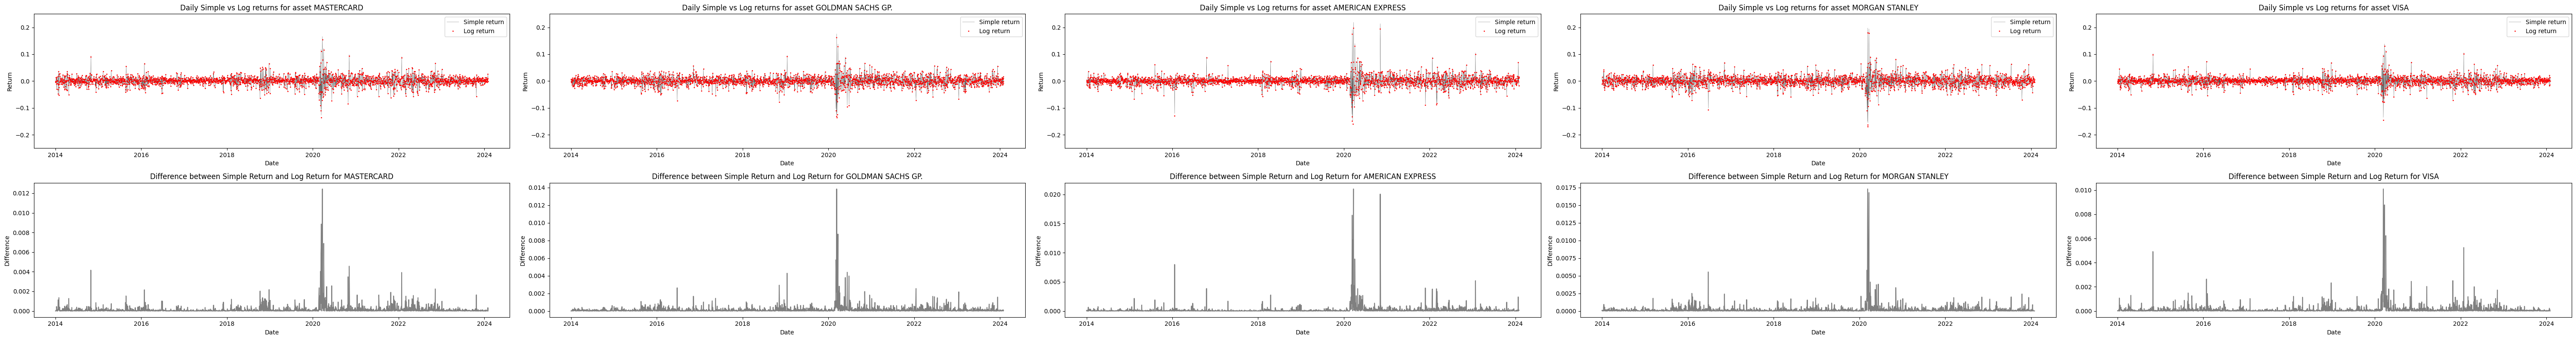

In [144]:
# Set up subplots
fig, axes = plt.subplots(nrows=2, ncols=len(Daily_simple_return.columns), figsize=(12*len(Daily_simple_return.columns), 8))
list_stocks = ['MASTERCARD','GOLDMAN SACHS GP.','AMERICAN EXPRESS','MORGAN STANLEY','VISA']
# Plot simple and log returns in the first row, and difference in the second row for each column
for i, (simple_column, log_column) in enumerate(zip(Daily_simple_return.columns, Daily_log_return.columns)):
    # Plot simple and log returns
    axes[0, i].plot(Daily_simple_return.index, Daily_simple_return[simple_column], color='black', label=f'{simple_column} Simple Return', linewidth=0.2)
    axes[0, i].plot(Daily_log_return.index, Daily_log_return[log_column], 'o', markersize=1, color='red', label=f'{log_column} Log Return')
    axes[0, i].set_xlabel('Date')
    axes[0, i].set_ylabel('Return')
    axes[0, i].set_title(f'Daily Simple vs Log returns for asset {list_stocks[i]}')
    axes[0, i].legend(['Simple return', 'Log return'])
    axes[0, i].set_ylim(-0.25, 0.25)  # Set y-axis limits for both plots

    # Plot difference
    diff = Daily_simple_return[simple_column] - Daily_log_return[log_column]
    axes[1, i].plot(diff.index, diff, color='grey', linestyle='-', label='Difference')
    axes[1, i].set_xlabel('Date')
    axes[1, i].set_ylabel('Difference')
    axes[1, i].set_title(f'Difference between Simple Return and Log Return for {list_stocks[i]}')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

Q1.2 Compare simple return and log-returns in weekly frequency.

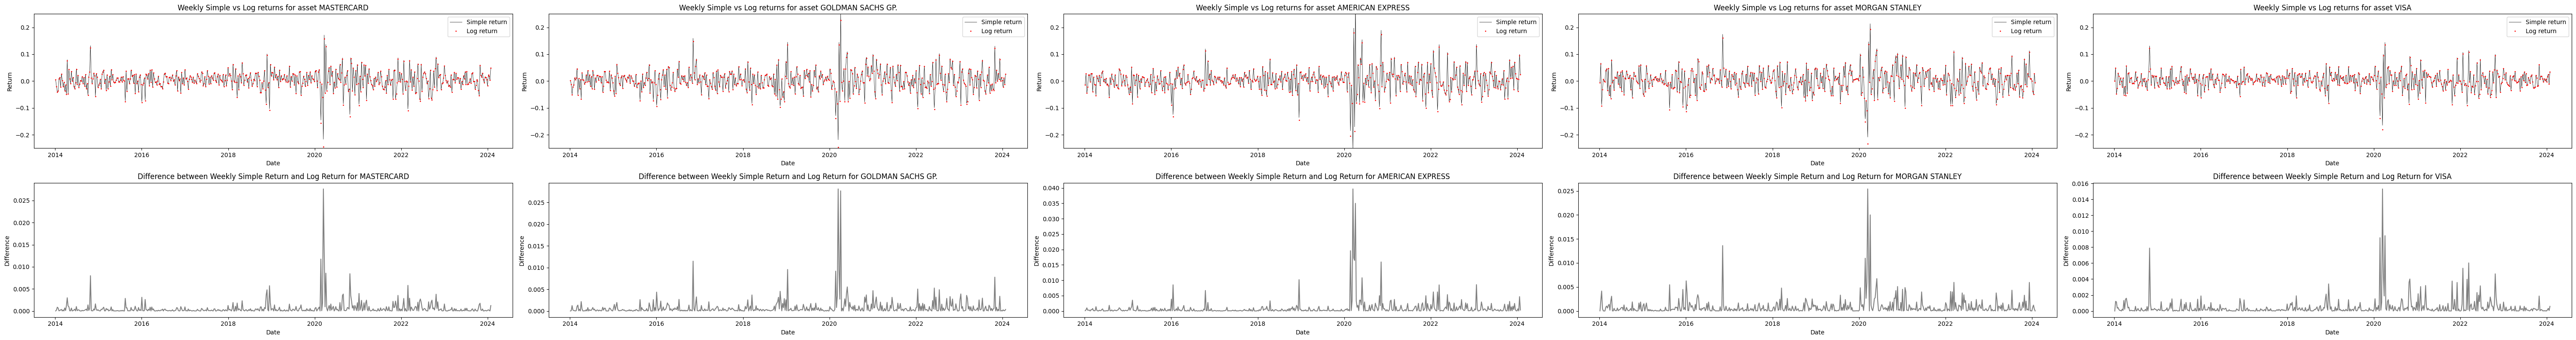

In [145]:
# Set up subplots
fig, axes = plt.subplots(nrows=2, ncols=len(Weekly_simple_return.columns), figsize=(12*len(Weekly_simple_return.columns), 8))

# Plot simple and log returns in the first row, and difference in the second row for each column

for i, (simple_column, log_column) in enumerate(zip(Weekly_simple_return.columns, Weekly_log_return.columns)):
    # Plot simple and log returns
    axes[0, i].plot(Weekly_simple_return.index, Weekly_simple_return[simple_column], color='black', linewidth=0.5, label=f'{simple_column} Simple Return')
    axes[0, i].plot(Weekly_log_return.index, Weekly_log_return[log_column], 'o', markersize=1, color='red', label=f'{log_column} Log Return')
    axes[0, i].set_xlabel('Date')
    axes[0, i].set_ylabel('Return')
    axes[0, i].set_title(f'Weekly Simple vs Log returns for asset {list_stocks[i]}')
    axes[0, i].legend(['Simple return', 'Log return'])
    axes[0, i].set_ylim(-0.25, 0.25)  # Set y-axis limits for both plots

    # Plot difference
    diff = Weekly_simple_return[simple_column] - Weekly_log_return[log_column]
    axes[1, i].plot(diff.index, diff, color='grey', linestyle='-', label='Difference')
    axes[1, i].set_xlabel('Date')
    axes[1, i].set_ylabel('Difference')
    axes[1, i].set_title(f'Difference between Weekly Simple Return and Log Return for {list_stocks[i]}')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

# 2 Stationarity

In [146]:
# Regression tables 
for column in data.columns:
    log_price = np.log(data)
    lagged_log_price = log_price.shift(1)

    y = log_price[column]  # pt
    X = lagged_log_price[column]  # pt−1

    X = X.dropna()
    y = y.drop(y.index[0])

    # Add a constant to the independent variable
    X = sm.add_constant(X)

    # Fit the OLS regression model
    model = sm.OLS(y, X).fit()

    # Rename constant and beta coefficients in the summary table
    model_summary = model.summary2()
    model_summary.tables[1].rename(columns={'const': 'μ', column: 'ϕ'}, inplace=True)

    # Print the modified summary
    print(f"Regression results for column {column}:")
    print(model_summary)

    # Define filename for saving the regression results
    filename = f"Regression_results_{column}.txt"
    filepath = os.path.join(output_directory, filename)




Regression results for column MA:
                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.999      
Dependent Variable: MA               AIC:                -14035.4770
Date:               2024-04-12 11:58 BIC:                -14023.7260
No. Observations:   2632             Log-Likelihood:     7019.7     
Df Model:           1                F-statistic:        3.359e+06  
Df Residuals:       2630             Prob (F-statistic): 0.00       
R-squared:          0.999            Scale:              0.00028266 
-----------------------------------------------------------------------
         Coef.     Std.Err.        t        P>|t|      [0.025    0.975]
-----------------------------------------------------------------------
const    0.0025      0.0029       0.8538    0.3933    -0.0032    0.0081
MA       0.9997      0.0005    1832.8004    0.0000     0.9986    1.0007
--------------------------------------------------------------------
Omni

In [147]:
# Regression tables 
for column in data.columns:
    log_price = np.log(data)
    lagged_log_price = log_price.shift(1)

    y = log_price[column]  # pt
    X = lagged_log_price[column]  # pt−1

    X = X.dropna()
    y = y.drop(y.index[0])

    # Add a constant to the independent variable
    X = sm.add_constant(X)

    # Fit the OLS regression model
    model = sm.OLS(y, X).fit()

    # Rename constant and beta coefficients in the summary table
    model_summary = model.summary2()
    model_summary.tables[1].rename(columns={'const': 'μ', column: 'ϕ'}, inplace=True)

    # Print the modified summary
    print(f"Regression results for column {column}:")
    print(model_summary)

    # Define filename for saving the regression results
    filename = f"Regression_results_{column}.txt"
    filepath = os.path.join(output_directory, filename)

 






   

Regression results for column MA:
                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.999      
Dependent Variable: MA               AIC:                -14035.4770
Date:               2024-04-12 11:58 BIC:                -14023.7260
No. Observations:   2632             Log-Likelihood:     7019.7     
Df Model:           1                F-statistic:        3.359e+06  
Df Residuals:       2630             Prob (F-statistic): 0.00       
R-squared:          0.999            Scale:              0.00028266 
-----------------------------------------------------------------------
         Coef.     Std.Err.        t        P>|t|      [0.025    0.975]
-----------------------------------------------------------------------
const    0.0025      0.0029       0.8538    0.3933    -0.0032    0.0081
MA       0.9997      0.0005    1832.8004    0.0000     0.9986    1.0007
--------------------------------------------------------------------
Omni

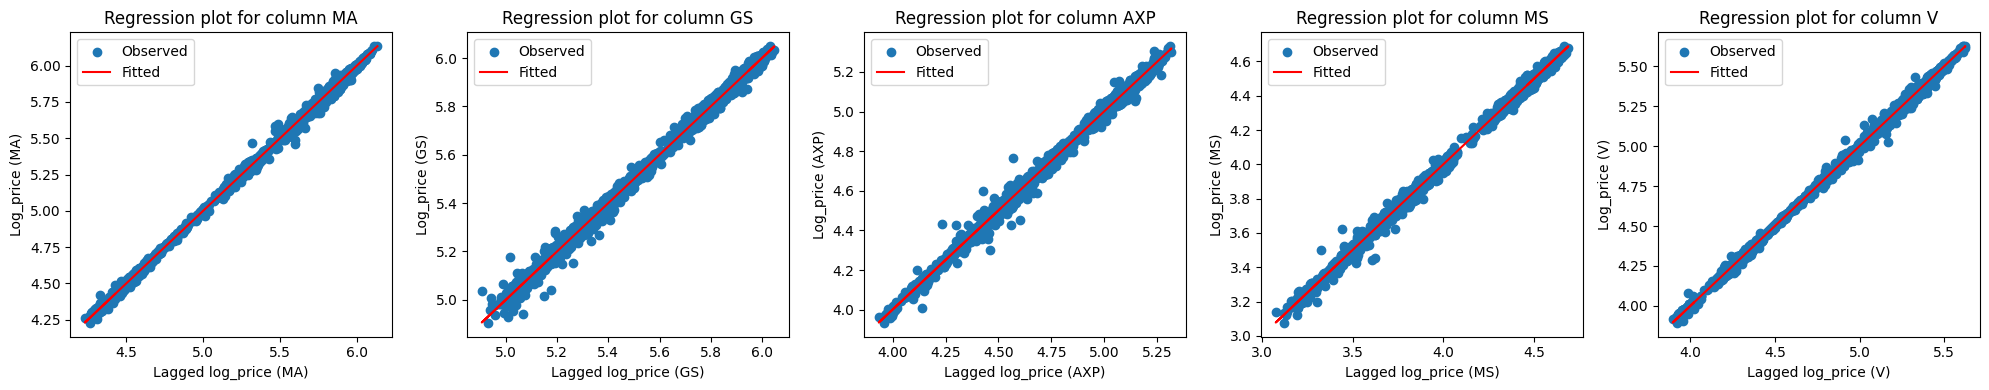

In [148]:
#plot of the regressions

# Number of columns per row
columns_per_row = 5

# Calculate the number of rows needed
num_rows = (len(data.columns) + columns_per_row - 1) // columns_per_row

# Create subplots
fig, axs = plt.subplots(num_rows, columns_per_row, figsize=(20, 4*num_rows))

# Flatten the axis array if it's multidimensional
axs = axs.flatten()

# Plot each regression
for i, column in enumerate(data.columns):
    log_price = np.log(data)
    lagged_log_price = log_price.shift(1)

    y = log_price[column]  # pt
    X = lagged_log_price[column]  # pt−1

    X = X.dropna()
    y = y.drop(y.index[0])

    # Add a constant to the independent variable
    X = sm.add_constant(X)

    # Fit the OLS regression model
    model = sm.OLS(y, X).fit()

    # Extract the fitted values
    fitted_values = model.fittedvalues

    # Plot the observed data points
    axs[i].scatter(X.iloc[:, 1], y, label='Observed')

    # Plot the fitted regression line
    axs[i].plot(X.iloc[:, 1], fitted_values, color='red', label='Fitted')

    # Add labels and legend
    axs[i].set_xlabel(f'Lagged log_price ({column})')
    axs[i].set_ylabel(f'Log_price ({column})')
    axs[i].set_title(f'Regression plot for column {column}')
    axs[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()

Monte-Carlo simulation

1. Simulate a time series of T error terms ε(i)
t , t = 1, . . . , T distributed as N(0, 1). T is the
length of your series.

2. Compute a time series of prices, assuming that they are driven by a random walk p(i)
t =
p(i)
t−1 + ε(i)
t .

3. Estimate the AR(1) model p(i)
t = μ(i) + ϕ(i)p(i)
t−1 + ε(i)
t .

4. Compute the test statistic t(ϕ(i) − 1) for the null hypothesis of the DF test.

Repeat this experiment N times to obtain the distribution of t(ϕ(i) − 1). The critical values
correspond to the quantiles at 10%, 5%, and 1% of the distribution t(ϕ(i) − 1).

In [149]:
N=10000
test_stats = np.zeros(N)
# Simulations Monte Carlo
for i in range(N):
    
    
    T = len(y)
    # Étape 1 : Simulation de T erreurs distribuées selon N(0, 1)
    errors = np.random.normal(0, 1, T)

    # Étape 2 : Calcul d'une série de prix en utilisant le modèle de marche aléatoire
    prices = np.cumsum(errors)

    # Étape 3 : Estimation du modèle AR(1)
    lagged_prices = np.roll(prices, 1)
    lagged_prices[0] = 0  # Réglez la première valeur à 0 pour le décalage
    X = np.column_stack((np.ones(T), lagged_prices))
    y = prices
    coefficients = np.linalg.inv(X.T @ X) @ X.T @ y

    # Étape 4 : Calcul de la statistique de test t(ϕ(i) − 1)
    phi_hat = coefficients[1]
    mu_hat = coefficients[0]
    test_stats[i] = (phi_hat - 1) / np.sqrt((np.sum((prices - mu_hat - phi_hat*lagged_prices)**2)/(T-2)) / np.sum((lagged_prices - np.mean(prices))**2))

# Compute critical values for the Dickey-Fuller test
critical_values = np.percentile(test_stats, [1, 5, 10])


In [150]:
print("Valeurs critiques basées sur les simulations Monte Carlo:")
print("1%: ", critical_values[0])
print("5%: ", critical_values[1])
print("10%: ", critical_values[2])

Valeurs critiques basées sur les simulations Monte Carlo:
1%:  -3.4364906303709075
5%:  -2.836557979562009
10%:  -2.554729390385655


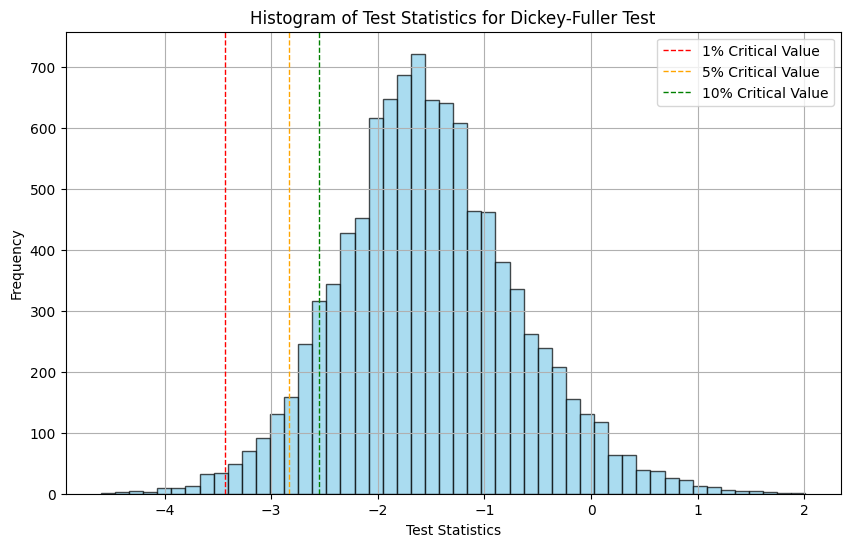

In [151]:
# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(test_stats, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Test Statistics')
plt.ylabel('Frequency')
plt.title('Histogram of Test Statistics for Dickey-Fuller Test')
plt.axvline(critical_values[0], color='red', linestyle='dashed', linewidth=1, label='1% Critical Value')
plt.axvline(critical_values[1], color='orange', linestyle='dashed', linewidth=1, label='5% Critical Value')
plt.axvline(critical_values[2], color='green', linestyle='dashed', linewidth=1, label='10% Critical Value')
plt.legend()
plt.grid(True)
plt.show()

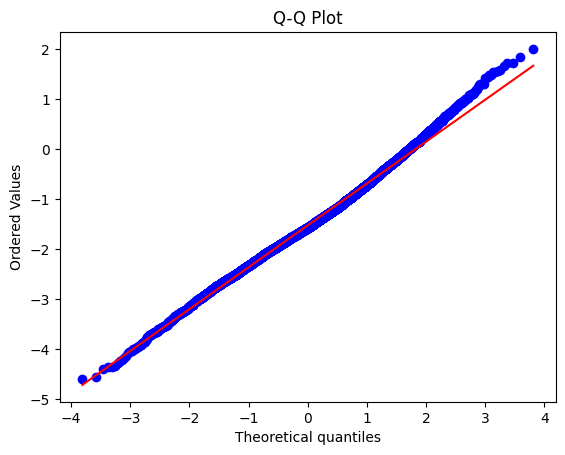

Shapiro-Wilk Test:
Test Statistic: 0.9952568859107718
P-value: 1.2841019238808589e-17

Anderson-Darling Test:
AD Statistic: 13.87052651308295
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Levels: [15.  10.   5.   2.5  1. ]
Skewness: 0.23937929028626398
Kurtosis: 0.42109714474906035


In [152]:
# look like to a normal distribution

# Test for normality

# Q-Q Plot
stats.probplot(test_stats, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

# Shapiro-Wilk Test
shapiro_statistic, shapiro_p_value = stats.shapiro(test_stats)
print('Shapiro-Wilk Test:')
print('Test Statistic:', shapiro_statistic)
print('P-value:', shapiro_p_value)

# Anderson-Darling Test
ad_statistic, ad_critical_values, ad_significance_levels = stats.anderson(test_stats, dist='norm')
print('\nAnderson-Darling Test:')
print('AD Statistic:', ad_statistic)
print('Critical Values:', ad_critical_values)
print('Significance Levels:', ad_significance_levels)

# Skewness and Kurtosis
skewness_value = stats.skew(test_stats)
kurtosis_value = stats.kurtosis(test_stats)
print('Skewness:', skewness_value)
print('Kurtosis:', kurtosis_value)

In [153]:
#Q2.7 Assume we redo the simulations, but this time we simulate the following AR(1) process p(i)t = 0.2 p(i)t−1 + ε(i)t . What would be the distribution of t(ϕ(i) − 1)?
test_stats_2 = np.zeros(N)
for i in range(N):
  
    T = 500
    # Step 1: Generate T errors distributed as N(0,1)
    errors = np.random.normal(0, 1, T)

    # Step 2: Compute a time series of prices using the modified AR(1) model
    prices = np.zeros(T)
    for t in range(1, T):
        prices[t] = 0.2 * prices[t-1] + errors[t]

    # Step 3: Estimation of the modified AR(1) model
    lagged_prices = np.roll(prices, 1)
    lagged_prices[0] = 0  # Set the first value to 0 for the lag
    X = np.column_stack((np.ones(T), lagged_prices))
    y = prices
    coefficients = np.linalg.inv(X.T @ X) @ X.T @ y

    # Step 4: Calculation of the test statistic t(phi(i) - 1)
    phi_hat = coefficients[1]
    mu_hat = coefficients[0]
    test_stats_2[i] = (phi_hat - 1) / np.sqrt((np.sum((prices - mu_hat - phi_hat*lagged_prices)**2)/(T-2)) / np.sum((lagged_prices - np.mean(prices))**2))






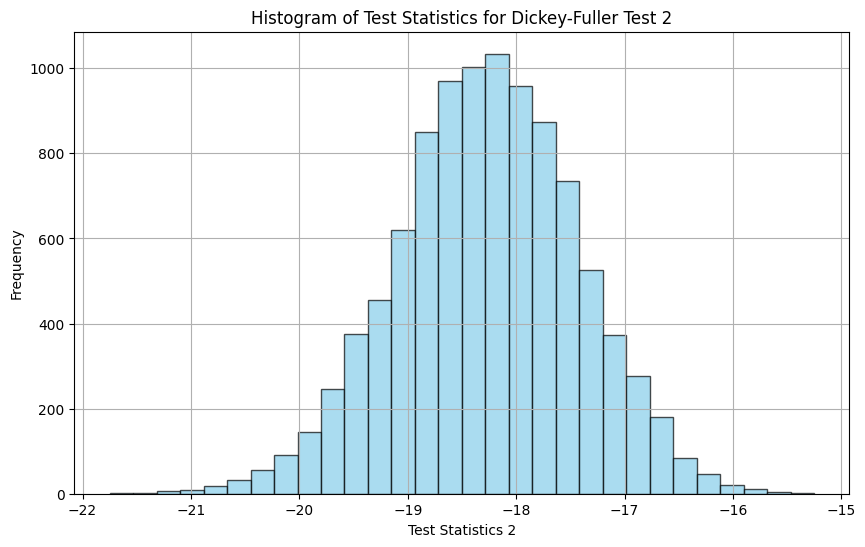

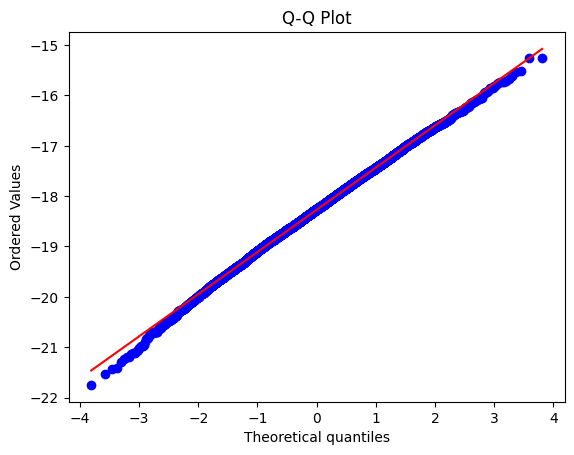

Shapiro-Wilk Test:
Test Statistic: 0.9991980213801932
P-value: 0.0001050431518402104

Anderson-Darling Test:
AD Statistic: 1.191080374754165
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Levels: [15.  10.   5.   2.5  1. ]
Skewness: -0.10917597612880242
Kurtosis: 0.08633627767105345


In [154]:
#2.7 Tests for the distribution

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(test_stats_2, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Test Statistics 2')
plt.ylabel('Frequency')
plt.title('Histogram of Test Statistics for Dickey-Fuller Test 2')
plt.grid(True)
plt.show()
# look like to a normal distribution

# Test for normality

# Q-Q Plot
stats.probplot(test_stats_2, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

# Shapiro-Wilk Test
shapiro_statistic, shapiro_p_value = stats.shapiro(test_stats_2)
print('Shapiro-Wilk Test:')
print('Test Statistic:', shapiro_statistic)
print('P-value:', shapiro_p_value)

# Anderson-Darling Test
ad_statistic, ad_critical_values, ad_significance_levels = stats.anderson(test_stats_2, dist='norm')
print('\nAnderson-Darling Test:')
print('AD Statistic:', ad_statistic)
print('Critical Values:', ad_critical_values)
print('Significance Levels:', ad_significance_levels)

# Skewness and Kurtosis
skewness_value = stats.skew(test_stats_2)
kurtosis_value = stats.kurtosis(test_stats_2)
print('Skewness:', skewness_value)
print('Kurtosis:', kurtosis_value)

In [155]:
t_stats = []
for column in log_price.columns:
    T = len(y)
    # Create lagged values for the current column
    lagged_log_price[column] = log_price[column].shift(1)
    
    # Drop NaN values from X
    X = lagged_log_price[column].values.reshape(-1, 1)  # Reshape to a 2D array as required by AutoReg
    X = X[~np.isnan(X)]  # Drop NaN values
    
    # Prepare the lagged and target variables for model fitting
    y = log_price[column].iloc[1:]  # Remove the first NaN value from the current column
    y = y[~y.isna()]  # Drop NaN values from y
    
    # Set frequency explicitly
    y.index.freq = 'B'  # Assuming frequency is business day
    
    # Fit an AR(1) model
    model = AutoReg(y, lags=1).fit()
    
    phi_hat = model.params.iloc[1]
    mu_hat = model.params.iloc[0]
    
    # Calculate the test statistic t(ϕ(i) − 1)
    t_stat = (phi_hat - 1) / np.sqrt((np.sum((y - mu_hat - phi_hat*X)**2)/(T-2)) / np.sum((X - np.mean(y))**2))
    
    # Append the calculated t-statistic to the list
    t_stats.append(t_stat)

# Your provided critical values for significance levels 1%, 5%, and 10%
critical_values = {
    0.01: critical_values[0],
    0.05: critical_values[1],
    0.1: critical_values[2]
}

# Loop through each t-statistic and compare with your critical values
for i, t_stat in enumerate(t_stats):
    column = log_price.columns[i]  # Get the column name
    for alpha, crit_val in critical_values.items():
        if t_stat < crit_val:
            print(f"For {column}, Test Statistic: {t_stat:.2f} < Critical Value ({alpha}%): {crit_val}. Reject null hypothesis at {alpha} level of significance.")
        else:
            print(f"For {column}, Test Statistic: {t_stat:.2f} > Critical Value ({alpha}%): {crit_val}. Fail to reject null hypothesis at {alpha} level of significance.")

For MA, Test Statistic: -0.28 > Critical Value (0.01%): -3.4364906303709075. Fail to reject null hypothesis at 0.01 level of significance.
For MA, Test Statistic: -0.28 > Critical Value (0.05%): -2.836557979562009. Fail to reject null hypothesis at 0.05 level of significance.
For MA, Test Statistic: -0.28 > Critical Value (0.1%): -2.554729390385655. Fail to reject null hypothesis at 0.1 level of significance.
For GS, Test Statistic: -1.24 > Critical Value (0.01%): -3.4364906303709075. Fail to reject null hypothesis at 0.01 level of significance.
For GS, Test Statistic: -1.24 > Critical Value (0.05%): -2.836557979562009. Fail to reject null hypothesis at 0.05 level of significance.
For GS, Test Statistic: -1.24 > Critical Value (0.1%): -2.554729390385655. Fail to reject null hypothesis at 0.1 level of significance.
For AXP, Test Statistic: -0.83 > Critical Value (0.01%): -3.4364906303709075. Fail to reject null hypothesis at 0.01 level of significance.
For AXP, Test Statistic: -0.83 > C

In [156]:


from scipy.stats import t
# Compute the p-value for each t-statistic
p_values = [2 * (1 - t.cdf(np.abs(t_stat), T-2)) for t_stat in t_stats]

# Now, you have the p-values corresponding to each t-statistic in the list p_values
# Loop through each p-value and print the result
for i, p_value in enumerate(p_values):
    column = log_price.columns[i]  # Get the column name
    print(f"For {column}, p-value: {p_value:.4f}")
    

For MA, p-value: 0.7817
For GS, p-value: 0.2162
For AXP, p-value: 0.4044
For MS, p-value: 0.2522
For V, p-value: 0.3241


# 3 Cointegration

First, we estimate their relationship by running a regression between their contemporaneous
log-prices:
pAt= α + βpBt+ zt

In [157]:
# Assuming you have a DataFrame called stock_prices with each column representing a stock price
# For example:
# stock_prices = pd.DataFrame({'Stock_A': [10, 12, 14, 16], 'Stock_B': [9, 11, 13, 15], ...})

# List to store regression results
regression_results = []

# Loop through each pair of stocks
for i, stock_A in enumerate(log_price.columns):
    for j, stock_B in enumerate(log_price.columns):
        if i != j:  # Ensure we're not doing a regression of a stock against itself
            # Extract stock prices
            X = log_price[stock_B]
            y = log_price[stock_A]

            # Add constant term for intercept
            X = sm.add_constant(X)

            # Fit OLS model
            model = sm.OLS(y, X).fit()

            # Append regression results
            regression_results.append({
                'Stock_A (y)': stock_A,
                'Stock_B (X)': stock_B,
                'Alpha': model.params['const'],
                'Beta': model.params[stock_B],
             
            })

# Convert results to DataFrame
regression_results_df = pd.DataFrame(regression_results)



In [158]:
regression_results_df

Stock_A (y) Stock_B (X)     Alpha      Beta
0           MA          GS -3.568300  1.614667
1           MA         AXP -2.273156  1.611175
2           MA          MS  0.294351  1.261416
3           MA           V -0.468950  1.174615
4           GS          MA  3.534594  0.367166
5           GS         AXP  1.856856  0.772051
6           GS          MS  2.774174  0.684068
7           GS           V  3.365602  0.430624
8          AXP          MA  2.220468  0.466553
9          AXP          GS -0.700020  0.983162
10         AXP          MS  1.800266  0.730337
11         AXP           V  2.077262  0.532505
12          MS          MA  0.867691  0.583171
13          MS          GS -3.667141  1.390776
14          MS         AXP -1.515653  1.166010
15          MS           V  0.620714  0.679561
16           V          MA  0.440506  0.843487
17           V          GS -2.558010  1.359882
18           V         AXP -1.297139  1.320530
19           V          MS  0.722004  1.055539

Then, we use the Dickey-Fuller test for testing the null of unit root in zt. So we estimate the
regression
Δˆzt = μ + ϕˆzt−1 + εt

In [159]:
t_test_results_PO = {}
# Loop through each pair of stocks
for i, stock_A in enumerate(log_price.columns):
    for j, stock_B in enumerate(log_price.columns):
        if i != j:  # Ensure we're not doing a regression of a stock against itself
            # Extract stock prices
            X = log_price[stock_B]
            y = log_price[stock_A]

            # Add constant term for intercept
            X = sm.add_constant(X)

            # Fit OLS model
            model = sm.OLS(y, X).fit()

            # Compute the residuals from the regression
            residuals = model.resid

            # Compute the first differences of the residuals
            delta_residuals = residuals.diff().dropna()

            # Lag the first differences of the residuals
            lagged_residuals = residuals.shift(1).dropna()

            # Add constant term for intercept
            lagged_residuals = sm.add_constant(lagged_residuals)

            # Run a regression of the first differences of the residuals on the lagged first differences of the residuals
            model = sm.OLS(delta_residuals, lagged_residuals).fit()

            # Extract the estimated coefficients + t_stat
            mu_hat = model.params.iloc[0]
            phi_hat = model.params.iloc[1]  
            dof = len(delta_residuals) - 2  # degrees of freedom
            t_stat = phi_hat / np.sqrt((np.sum((delta_residuals - mu_hat - phi_hat * lagged_residuals.iloc[:, 1])**2) / (T - 2)) / np.sum((lagged_residuals.iloc[:, 1] - np.mean(delta_residuals))**2))
            p_value = stats.t.sf(np.abs(t_stat), df=dof) * 2  # two-tailed test
            t_test_results_PO[(stock_A, stock_B)] = (t_stat, p_value)

            # Print the estimated coefficients
            print(f"For pair ({stock_A}, {stock_B}):")
            print("Intercept (mu_hat):", mu_hat)
            print("Coefficient of lagged first difference of residuals (phi_hat):", phi_hat)
            print("t-stat :", t_stat)
            print("p-value:", p_value)

For pair (MA, GS):
Intercept (mu_hat): 0.0001681658169123962
Coefficient of lagged first difference of residuals (phi_hat): -0.001951743367099204
t-stat : -1.6757174134809618
p-value: 0.09391242370531494
For pair (MA, AXP):
Intercept (mu_hat): 0.00014566621013321912
Coefficient of lagged first difference of residuals (phi_hat): -0.0035898319263266746
t-stat : -2.3853427167578483
p-value: 0.017133630741123555
For pair (MA, MS):
Intercept (mu_hat): 0.0001579275013277477
Coefficient of lagged first difference of residuals (phi_hat): -0.0019811894072810803
t-stat : -1.6197517515136024
p-value: 0.10540550545531864
For pair (MA, V):
Intercept (mu_hat): -6.776931772859077e-05
Coefficient of lagged first difference of residuals (phi_hat): -0.011817067930569303
t-stat : -4.276283476850232
p-value: 1.9681610891291742e-05
For pair (GS, MA):
Intercept (mu_hat): 5.915937774939977e-05
Coefficient of lagged first difference of residuals (phi_hat): -0.0030666495383798757
t-stat : -1.9558128843728824
p

For pair (GS, MS):
Intercept (mu_hat): 3.103489326419154e-05
Coefficient of lagged first difference of residuals (phi_hat): -0.009412284457326989
t-stat : -3.402526298200958
p-value: 0.0006776443979460118
For pair (GS, V):
Intercept (mu_hat): 3.4672757129663235e-05
Coefficient of lagged first difference of residuals (phi_hat): -0.0030105531223219005
t-stat : -1.9494191752748469
p-value: 0.05135154153905808
For pair (AXP, MA):
Intercept (mu_hat): 9.305181173277362e-06
Coefficient of lagged first difference of residuals (phi_hat): -0.004178143298762203
t-stat : -2.322047883917469
p-value: 0.020306362558313647
For pair (AXP, GS):
Intercept (mu_hat): 1.955693206795278e-05
Coefficient of lagged first difference of residuals (phi_hat): -0.0038898987199657478
t-stat : -2.2316778402819786
p-value: 0.025720209290132967
For pair (AXP, MS):
Intercept (mu_hat): 2.7758821759241696e-05
Coefficient of lagged first difference of residuals (phi_hat): -0.005397680992139041
t-stat : -2.5700400867844344
p

3.1 Critical Values
The critical values for this test with T = 100 are −3.07 at 10%, −3.37 at 5%, and −3.96 at 1%
provided by Phillips and Ouliaris (1988). As before, we would like to compute our own critical
values for our sample size. We run the following simulation exercise:

1. Simulate two time series of independent random walks: pA(i)
t = pA(i)
t−1 +εA(i)
t and pB(i)
t =
pB(i)
t−1 + εB(i)
t for t = 1, ..., T. Error terms εA(i)
t and εB(i)
t , t = 1, . . . , T, are distributed as
independent N(0, 1).

2. Estimate the linear relationship between the two time series (pAt
, pBt
):
pA(i)
t = α + βpB(i)
t + z(i)

In [160]:
test_stats_3 = np.zeros(N)
# Simulations Monte Carlo
for i in range(N):
    
    T = len(data['MA'])
    #Simulate random walks
    errors_a = np.random.normal(0, 1, T)
    errors_b = np.random.normal(0, 1, T)
    prices_a = np.cumsum(errors_a)
    prices_b = np.cumsum(errors_b)

    # Estimation of the model
    
    w = prices_a
    V = np.column_stack((np.ones(T), prices_b))
    model_1 = sm.OLS(w, V).fit()
  
    # Compute the residuals from the regression
    
    residuals =  model_1.resid

    # Convert residuals to a pandas Series
    residuals_series = pd.Series(residuals)

    # Compute the first differences of the residuals
    delta_residuals = residuals_series.diff().dropna()

    # Lag the residuals
    lagged_residuals = residuals_series.shift(1).dropna()

    # Estimation of the second model
    y = delta_residuals
    T_2 = len(y)
    X = np.column_stack((np.ones(T_2), lagged_residuals))
    model_2 = sm.OLS(y, X).fit()
    

    # Calculation of coefficients and t_stat
    mu_hat = model_2.params.iloc[0]
    phi_hat = model_2.params.iloc[1]
    test_stats_3[i] = phi_hat / np.sqrt((np.sum((delta_residuals - mu_hat - phi_hat * lagged_residuals)**2) / (T - 2)) / np.sum((lagged_residuals - np.mean(delta_residuals))**2))


# Compute critical values for the Dickey-Fuller test
critical_values_3 = np.percentile(test_stats_3, [1, 5, 10])

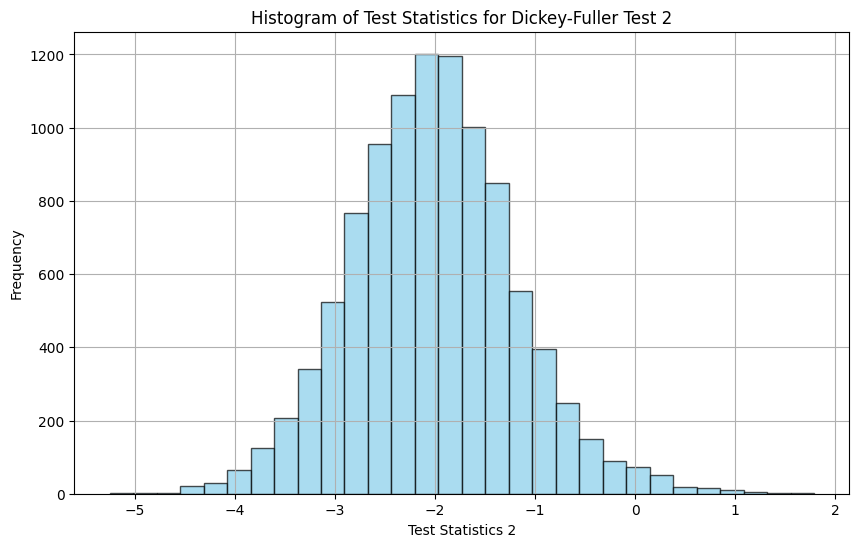

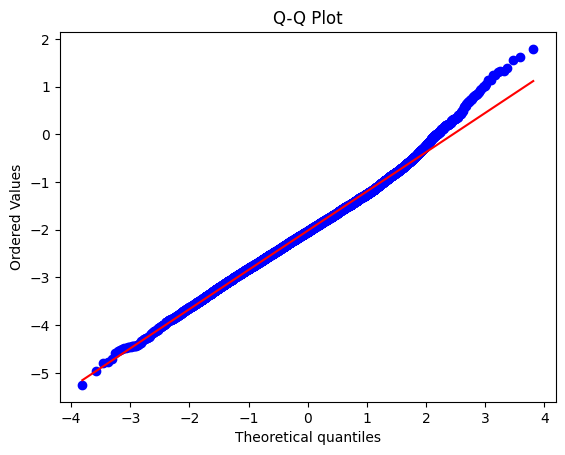

Shapiro-Wilk Test:
Test Statistic: 0.9950970185135856
P-value: 5.973660623654432e-18

Anderson-Darling Test:
AD Statistic: 7.621518149258918
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Levels: [15.  10.   5.   2.5  1. ]
Skewness: 0.22877949218101132
Kurtosis: 0.6057387951914235


In [161]:
#3.1 Tests for the distribution T = 2632

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(test_stats_3, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Test Statistics 2')
plt.ylabel('Frequency')
plt.title('Histogram of Test Statistics for Dickey-Fuller Test 2')
plt.grid(True)
plt.show()
# look like to a normal distribution

# Test for normality

# Q-Q Plot
stats.probplot(test_stats_3, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

# Shapiro-Wilk Test
shapiro_statistic, shapiro_p_value = stats.shapiro(test_stats_3)
print('Shapiro-Wilk Test:')
print('Test Statistic:', shapiro_statistic)
print('P-value:', shapiro_p_value)

# Anderson-Darling Test
ad_statistic, ad_critical_values, ad_significance_levels = stats.anderson(test_stats_3, dist='norm')
print('\nAnderson-Darling Test:')
print('AD Statistic:', ad_statistic)
print('Critical Values:', ad_critical_values)
print('Significance Levels:', ad_significance_levels)

# Skewness and Kurtosis
skewness_value = stats.skew(test_stats_3)
kurtosis_value = stats.kurtosis(test_stats_3)
print('Skewness:', skewness_value)
print('Kurtosis:', kurtosis_value)

In [162]:
print("Critical values based on the Monte-Carlo simulation with T = 10000:")
print("1%: ", critical_values_3[0])
print("5%: ", critical_values_3[1])
print("10%: ", critical_values_3[2])

Critical values based on the Monte-Carlo simulation with T = 10000:
1%:  -3.883529175314749
5%:  -3.34012283660983
10%:  -3.037463158849983


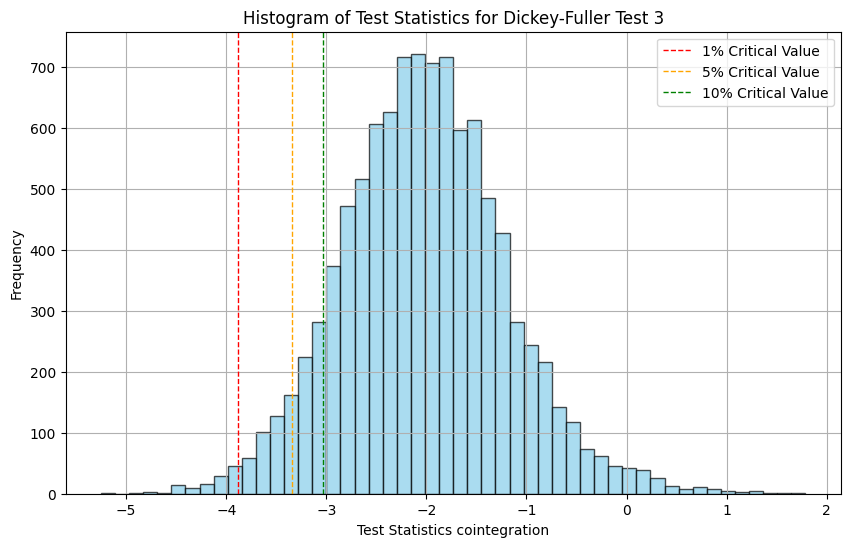

In [163]:
# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(test_stats_3, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Test Statistics cointegration')
plt.ylabel('Frequency')
plt.title('Histogram of Test Statistics for Dickey-Fuller Test 3')
plt.axvline(critical_values_3[0], color='red', linestyle='dashed', linewidth=1, label='1% Critical Value')
plt.axvline(critical_values_3[1], color='orange', linestyle='dashed', linewidth=1, label='5% Critical Value')
plt.axvline(critical_values_3[2], color='green', linestyle='dashed', linewidth=1, label='10% Critical Value')
plt.legend()
plt.grid(True)
plt.show()

The simulation for T = 500

In [164]:
test_stats_4 = np.zeros(N)
# Simulations Monte Carlo
for i in range(N):
    
    T = 500
    #Simulate random walks
    errors_a = np.random.normal(0, 1, T)
    errors_b = np.random.normal(0, 1, T)
    prices_a = np.cumsum(errors_a)
    prices_b = np.cumsum(errors_b)

    # Estimation of the model
    
    w = prices_a
    V = np.column_stack((np.ones(T), prices_b))
    model_1 = sm.OLS(w, V).fit()
  
    # Compute the residuals from the regression
    
    residuals =  model_1.resid

    # Convert residuals to a pandas Series
    residuals_series = pd.Series(residuals)

    # Compute the first differences of the residuals
    delta_residuals = residuals_series.diff().dropna()

    # Lag the residuals
    lagged_residuals = residuals_series.shift(1).dropna()

    # Estimation of the second model
    y = delta_residuals
    T_2 = len(y)
    X = np.column_stack((np.ones(T_2), lagged_residuals))
    model_2 = sm.OLS(y, X).fit()
    

    # Calculation of coefficients and t_stat
    mu_hat = model_2.params.iloc[0]
    phi_hat = model_2.params.iloc[1]
    test_stats_4[i] = phi_hat / np.sqrt((np.sum((delta_residuals - mu_hat - phi_hat * lagged_residuals)**2) / (T - 2)) / np.sum((lagged_residuals - np.mean(delta_residuals))**2))


# Compute critical values for the Dickey-Fuller test
critical_values_4 = np.percentile(test_stats_4, [1, 5, 10])

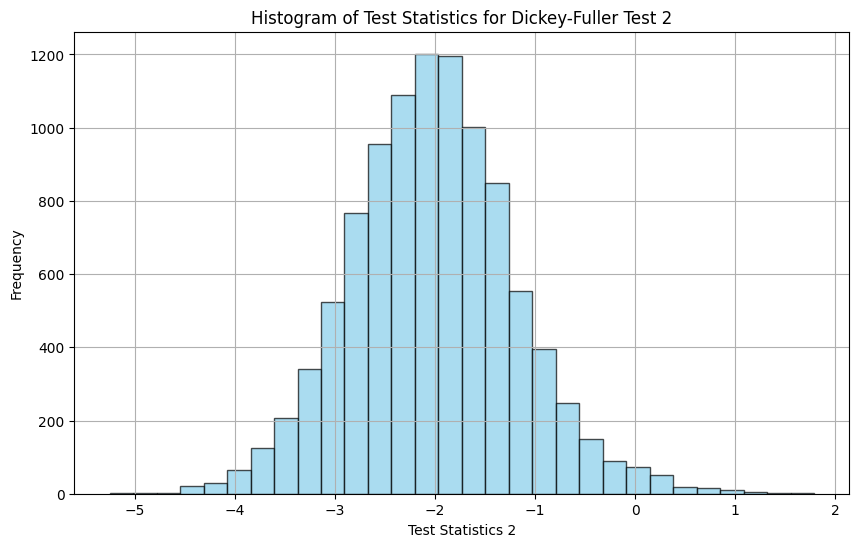

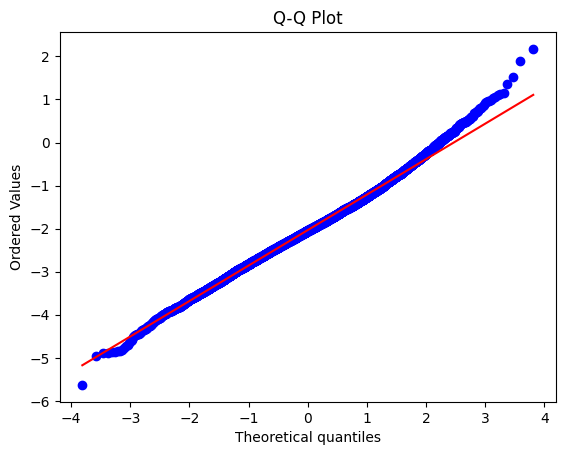

Shapiro-Wilk Test:
Test Statistic: 0.995731263126307
P-value: 1.3889392619654487e-16

Anderson-Darling Test:
AD Statistic: 8.88862854072795
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Levels: [15.  10.   5.   2.5  1. ]
Skewness: 0.195536866674614
Kurtosis: 0.5897731383656759


In [165]:
#3.1 Tests for the distribution T = 500

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(test_stats_3, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Test Statistics 2')
plt.ylabel('Frequency')
plt.title('Histogram of Test Statistics for Dickey-Fuller Test 2')
plt.grid(True)
plt.show()
# look like to a normal distribution

# Test for normality

# Q-Q Plot
stats.probplot(test_stats_4, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

# Shapiro-Wilk Test
shapiro_statistic, shapiro_p_value = stats.shapiro(test_stats_4)
print('Shapiro-Wilk Test:')
print('Test Statistic:', shapiro_statistic)
print('P-value:', shapiro_p_value)

# Anderson-Darling Test
ad_statistic, ad_critical_values, ad_significance_levels = stats.anderson(test_stats_4, dist='norm')
print('\nAnderson-Darling Test:')
print('AD Statistic:', ad_statistic)
print('Critical Values:', ad_critical_values)
print('Significance Levels:', ad_significance_levels)

# Skewness and Kurtosis
skewness_value = stats.skew(test_stats_4)
kurtosis_value = stats.kurtosis(test_stats_4)
print('Skewness:', skewness_value)
print('Kurtosis:', kurtosis_value)

In [166]:
print("Critical values based on the Monte-Carlo simulation with T = 500:")
print("1%: ", critical_values_4[0])
print("5%: ", critical_values_4[1])
print("10%: ", critical_values_4[2])

Critical values based on the Monte-Carlo simulation with T = 500:
1%:  -3.9115763183826715
5%:  -3.366464442329418
10%:  -3.0551162234809355


Analyse of the distribution

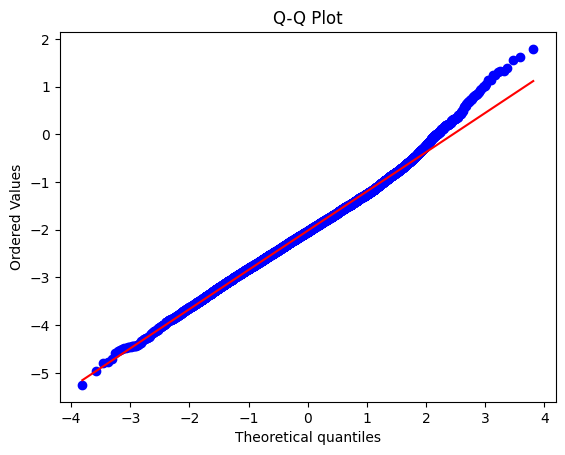

Shapiro-Wilk Test:
Test Statistic: 0.9950970185135856
P-value: 5.973660623654432e-18

Anderson-Darling Test:
AD Statistic: 7.621518149258918
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Levels: [15.  10.   5.   2.5  1. ]
Skewness: 0.22877949218101132
Kurtosis: 0.6057387951914235


In [167]:
# look like to a normal distribution

# Test for normality

# Q-Q Plot
stats.probplot(test_stats_3, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

# Shapiro-Wilk Test
shapiro_statistic, shapiro_p_value = stats.shapiro(test_stats_3)
print('Shapiro-Wilk Test:')
print('Test Statistic:', shapiro_statistic)
print('P-value:', shapiro_p_value)

# Anderson-Darling Test
ad_statistic, ad_critical_values, ad_significance_levels = stats.anderson(test_stats_3, dist='norm')
print('\nAnderson-Darling Test:')
print('AD Statistic:', ad_statistic)
print('Critical Values:', ad_critical_values)
print('Significance Levels:', ad_significance_levels)

# Skewness and Kurtosis
skewness_value = stats.skew(test_stats_3)
kurtosis_value = stats.kurtosis(test_stats_3)
print('Skewness:', skewness_value)
print('Kurtosis:', kurtosis_value)

Test for cointegration on each pair of assets (in both directions, i.e., A → B and B → A).

In [168]:
for i, (pair, result) in enumerate(t_test_results_PO.items()):
    t_stat, p_value = result
    if t_stat < critical_values_3[0]:
        print(f"({pair[0]} (y), {pair[1]} (X)): T_stat {t_stat:.4f}, Reject H0 (α = 1%, critical value {critical_values_3[0]:.4f}), Hence stationarity")
    elif t_stat < critical_values_3[1]:
        print(f"({pair[0]} (y), {pair[1]} (X)): T_stat {t_stat:.4f}, Reject H0 (α = 5%, critical value {critical_values_3[1]:.4f}), Hence stationarity")
    elif t_stat < critical_values_3[2]:
        print(f"({pair[0]} (y), {pair[1]} (X)): T_stat {t_stat:.4f}, Reject H0 (α = 10%, critical value {critical_values_3[2]:.4f}), Hence stationarity")
    else:
        print(f"({pair[0]} (y), {pair[1]} (X)): T_stat {t_stat:.4f}, Fail to Reject H0, Hence non-stationarity")

(MA (y), GS (X)): T_stat -1.6757, Fail to Reject H0, Hence non-stationarity
(MA (y), AXP (X)): T_stat -2.3853, Fail to Reject H0, Hence non-stationarity
(MA (y), MS (X)): T_stat -1.6198, Fail to Reject H0, Hence non-stationarity
(MA (y), V (X)): T_stat -4.2763, Reject H0 (α = 1%, critical value -3.8835), Hence stationarity
(GS (y), MA (X)): T_stat -1.9558, Fail to Reject H0, Hence non-stationarity
(GS (y), AXP (X)): T_stat -2.4822, Fail to Reject H0, Hence non-stationarity
(GS (y), MS (X)): T_stat -3.4025, Reject H0 (α = 5%, critical value -3.3401), Hence stationarity
(GS (y), V (X)): T_stat -1.9494, Fail to Reject H0, Hence non-stationarity
(AXP (y), MA (X)): T_stat -2.3220, Fail to Reject H0, Hence non-stationarity
(AXP (y), GS (X)): T_stat -2.2317, Fail to Reject H0, Hence non-stationarity
(AXP (y), MS (X)): T_stat -2.5700, Fail to Reject H0, Hence non-stationarity
(AXP (y), V (X)): T_stat -2.2234, Fail to Reject H0, Hence non-stationarity
(MS (y), MA (X)): T_stat -1.8725, Fail to R

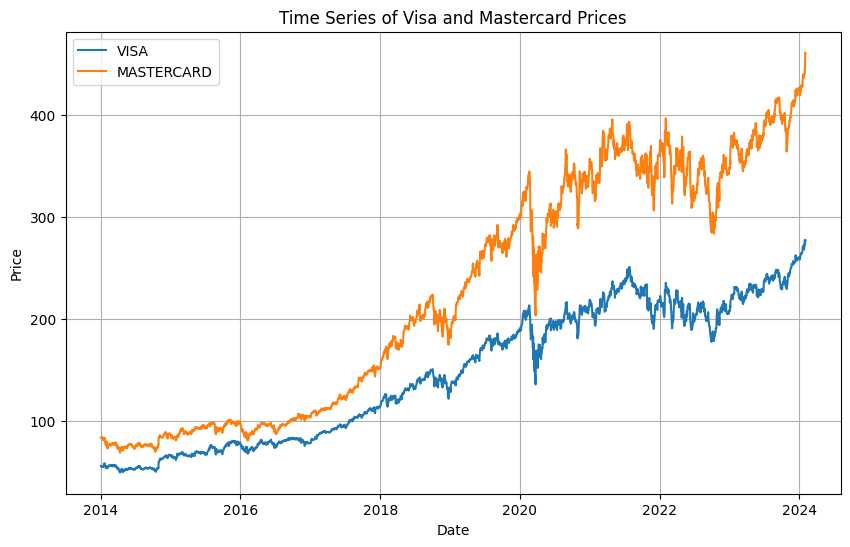

In [169]:
# Plot the time series of Visa and Mastercard prices
plt.figure(figsize=(10, 6))
plt.plot(data["V"], label='VISA')
plt.plot(data["MA"], label='MASTERCARD')
plt.title('Time Series of Visa and Mastercard Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# 4 Pair Trading
4.1 Trading Signal
Let the pair of assets (A,B) be cointegrated :
PAt = α + βPBt + zt, (2)
where PAt is the price of asset A and PAt the price of asset B.We use prices instead of log-pricesto simplify the construction of the pair-trading strategy.
We define the spread zt as:
zt = PAt − α − βPBt (3) The spread (or signal) is normalized as ˜z = zt/σ(zt).

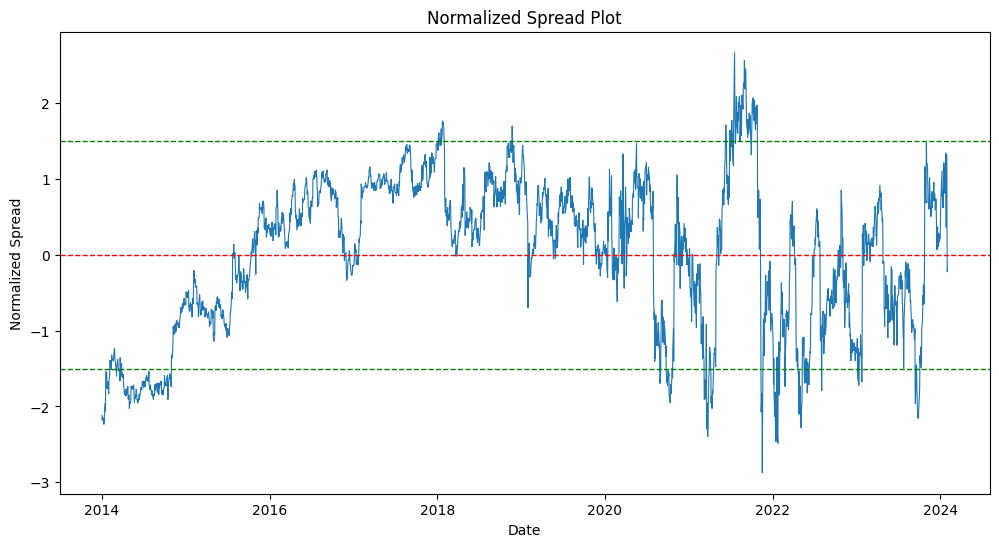

In [170]:
# In our case Pat = Visa and Pbt = Mastercard

# Set regression
y = data['V']
X = data['MA']
X = sm.add_constant(X)

# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Take the spread (residuals)
spread = model.resid

# Normalization of the spread
spread_norm = model.resid / np.sqrt(model.scale) 

# Plot the normalized spread
plt.figure(figsize=(12, 6))
plt.plot(spread_norm, linewidth=0.8)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1, label='Zero Line')
plt.axhline(y=-1.5, color='green', linestyle='--', linewidth=1, label='Zero Line')
plt.axhline(y=1.5, color='green', linestyle='--', linewidth=1, label='Zero Line')
plt.title('Normalized Spread Plot')
plt.xlabel('Date')
plt.ylabel('Normalized Spread')
plt.show()



Q4.3

<Figure size 1200x600 with 0 Axes>

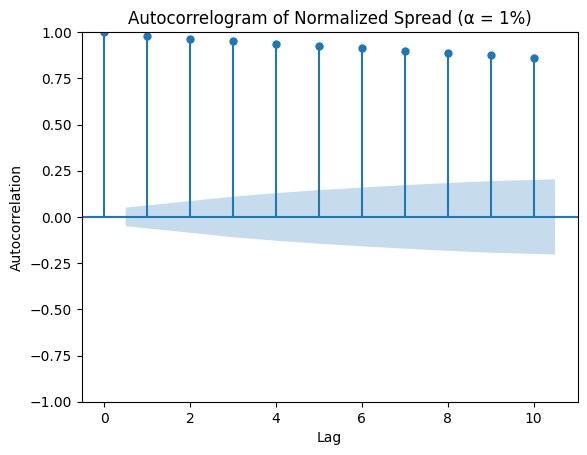

In [171]:
# Autocorrelation plot (auto-correlogram)
plt.figure(figsize=(12, 6))
plot_acf(spread_norm, lags=10, alpha=0.01)
plt.title('Autocorrelogram of Normalized Spread (α = 1%)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

In [172]:
# Perform Ljung-Box test with 10 lags
lb_test_results = sm.stats.acorr_ljungbox(spread_norm, lags=10)
lb_test_results

lb_stat  lb_pvalue
1    2531.213759        0.0
2    4976.461787        0.0
3    7355.929686        0.0
4    9677.320387        0.0
5   11941.350320        0.0
6   14141.498465        0.0
7   16280.682828        0.0
8   18363.591422        0.0
9   20384.976748        0.0
10  22336.964842        0.0

Q4.7 Implement the strategy of the investor described above with ˜zin = 1.5. What is
the profit? Report the final wealth, the largest and the lowest wealth level, and
the number of trades. Plot the signal ˜ zt, the evolution of wealth, the positions,
and the leverage.

In [173]:
# In our case Pat = Visa and Pbt = Mastercard

asset_A_prices = data['V']
asset_B_prices = data['MA']

# Set regression
y = data['V']
X = data['MA']
X = sm.add_constant(X)

# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Take the spread (residuals)
spread = model.resid

# Normalization of the spread
spread_norm = model.resid / np.sqrt(model.scale)

#get the coefficients
alpha = model.params['const']
beta = model.params['MA']

In [174]:
def TradingStrategy(
    P_A: pd.core.frame.DataFrame,
    P_B: pd.core.frame.DataFrame,
    normalized_res: np.array,
    W: float = 1000,
    L: float = 2,
    signal_in: float = 1.5,
    stop: float = None,
):
    """
    Function containing an algorithmic trading strategy to
    sell and buy the assets A and B according to cointegration pair trading arbitrage. 
    
    """

   # First, we initialize our variables
    short = np.zeros(len(P_A))
    long = np.zeros(len(P_A))

    wealth = np.zeros(len(P_A))
    wealth[0] = W
    
    Q_A = 0
    Q_B = 0
    signal = 0
    nb_trades = 0
    date_open = []
    date_close = []
    positions = [] # Track every trades positions
    current_trade = {} # Create a dictionary for every positions in order to track their informations


    # In order to use our conditions, we will initialize our
    # stop signal equal to infinity if he is not defined
    if stop == None:
        stop = float("inf")

    # Execute the trading strategy
    for i in range(len(P_A)):
        # Compute the Signal 1:
        if signal == 1:
            if (normalized_res.iloc[i] <= 0) or (normalized_res.iloc[i] > stop):
                # We close our positions and compute the wealth
                wealth[i] = wealth[i-1] + Q_B*(P_B[i]-P_B[i-1]) + Q_A*(P_A[i-1]-P_A[i])
                
                # Add the new existing informations into our dictionary about the position
                current_trade['zt_exit'] = normalized_res.iloc[i]
                current_trade['exit_observation'] = P_A.index[i]
                current_trade['mastercard_quantity'] = Q_B
                current_trade['mastercard_exit_price'] = P_B[i-1]
                current_trade['visa_quantity'] = Q_A
                current_trade['visa_exit_price'] = P_A[i-1]

                positions.append(current_trade) # Save the informations about our trade now that the position is closed 
                current_trade = {} # Reset current trade dictionary for the next position
               

                # Reset the values to zero as the positions are closed
                Q_A, Q_B = 0, 0
                short[i], long[i] = 0, 0
                signal = 0
                date_close.append(P_A.index[i])
                    
            elif normalized_res.iloc[i] > 0:
                # We take a short position in asset A and
                # a long position in asset B
                short[i] = Q_A*P_A[i]
                long[i] = Q_B*P_B[i]
                wealth[i] = wealth[i-1] + Q_B*(P_B[i]-P_B[i-1]) + Q_A*(P_A[i-1]-P_A[i])
               
        # Compute the Signal 2
        elif signal == 2:        
            if (normalized_res.iloc[i] >= 0) or (normalized_res.iloc[i] < -stop):
                # We close our positions and compute the wealth
                wealth[i] = wealth[i-1]+ Q_B*(P_B[i-1]-P_B[i]) + Q_A*(P_A[i]-P_A[i-1])


                # Add the new existing informations into our dictionary about the position
                current_trade['zt_exit'] = normalized_res.iloc[i]
                current_trade['exit_observation'] = P_A.index[i]
                current_trade['mastercard_quantity'] = Q_B
                current_trade['mastercard_exit_price'] = P_B[i-1]
                current_trade['visa_quantity'] = Q_A
                current_trade['visa_exit_price'] = P_A[i-1]

                positions.append(current_trade) # Save the informations about our trade now that the position is closed 
                current_trade = {} # Reset current trade dictionary for the next position

                
                # Reset the values to zero as the positions are closed
                Q_A, Q_B = 0, 0
                short[i], long[i] = 0, 0
                signal = 0
                date_close.append(P_A.index[i])
                    
            elif normalized_res.iloc[i] < 0:
                # We take a short position in asset B and
                # a long position in asset A
                short[i] = Q_B*P_B[i]
                long[i] = Q_A*P_A[i]
                wealth[i] = wealth[i-1] + Q_B*(P_B[i-1]-P_B[i]) + Q_A*(P_A[i]-P_A[i-1])
                
        elif signal == 0:
        
            if alpha > 0 :
                if normalized_res[i] > signal_in:
                    # We can determine the number of shares that we buy and sell.
                    # Here, we will short A and long B.
                    if i != 0 :
                        wealth[i] = wealth[i-1] 

                    Q_A = (L * wealth[i]) / P_A[i]
                    Q_B = beta * Q_A

                    short[i] = Q_A * P_A[i]
                    long[i] = Q_B * P_B[i]

                    signal = 1
                    nb_trades += 1
                    date_open.append(P_A.index[i])
                    
                    current_trade = { 
                        'entry_signal': "Signal 1", 
                        'zt_entry': normalized_res.iloc[i], 
                        'entry_observation': P_A.index[i], 
                        'mastercard_entry_price': P_B[i], 
                        'mastercard_quantity': Q_B, 
                        'visa_entry_price': P_A[i], 
                        'visa_quantity': Q_A
                    }   
                    
                elif normalized_res[i] < -signal_in:
                    # We can determine the number of shares that we buy and sell.
                    # Here, we will short B and long A.
                    # Solve for x
                    if i != 0 :
                        wealth[i] = wealth[i-1]
                    
                    Q_A = (L * wealth[i]) / (beta*P_B[i] + L*(P_A[i] - beta*P_B[i]))
                    Q_B = beta * Q_A

                    short[i] = Q_B * P_B[i]
                    long[i] = Q_A * P_A[i]
                    signal = 2
                    nb_trades += 1
                    date_open.append(P_A.index[i])
                    current_trade = { 
                        'entry_signal': "Signal 2", 
                        'zt_entry': normalized_res.iloc[i], 
                        'entry_observation': P_A.index[i], 
                        'mastercard_entry_price': P_B[i], 
                        'mastercard_quantity': Q_B, 
                        'visa_entry_price': P_A[i], 
                        'visa_quantity': Q_A
                    }   

                else:
                    short[i] = 0
                    long[i] = 0
                    if i != 0 :
                        wealth[i] = wealth[i-1]

            if alpha < 0 :
                if normalized_res[i] > signal_in:
                    # We can determine the number of shares that we buy and sell.
                    # Here, we will short A and long B.
                    if i != 0 :
                        wealth[i] = wealth[i-1]
                    
                    Q_A = (L * wealth[i]) / (P_A[i] - L*(P_A[i] - beta*P_B[i]))
                    Q_B = beta * Q_A

                    short[i] = Q_A * P_A[i]
                    long[i] = Q_B * P_B[i]
                    signal = 1
                    nb_trades += 1
                    date_open.append(P_A.index[i])
                    current_trade = { 
                        'entry_signal': "Signal 1", 
                        'zt_entry': normalized_res.iloc[i], 
                        'entry_observation': P_A.index[i], 
                        'mastercard_entry_price': P_B[i], 
                        'mastercard_quantity': Q_B, 
                        'visa_entry_price': P_A[i], 
                        'visa_quantity': Q_A
                    }   
                    
                elif normalized_res[i] < -signal_in:
                    # We can determine the number of shares that we buy and sell.
                    # Here, we will short B and long A.
                    # Solve for x
                    if i != 0 :
                        wealth[i] = wealth[i-1]
                    
                    Q_A = (L * wealth[i]) / (beta * P_B[i])
                    Q_B = beta * Q_A

                    short[i] = Q_B * P_B[i]
                    long[i] = Q_A * P_A[i]
                    signal = 2
                    nb_trades += 1
                    date_open.append(P_A.index[i])

                    current_trade = { 
                        'entry_signal': "Signal 2", 
                        'zt_entry': normalized_res.iloc[i], 
                        'entry_observation': P_A.index[i], 
                        'mastercard_entry_price': P_B[i], 
                        'mastercard_quantity': Q_B, 
                        'visa_entry_price': P_A[i], 
                        'visa_quantity': Q_A
                    }   

                else:
                    short[i] = 0
                    long[i] = 0
                    if i != 0 :
                        wealth[i] = wealth[i-1]   

    # Add the last date considered in date_close if the position is not closed.
    # This will be useful for graphics
    if date_close[-1] < date_open[-1]:
        date_close.append(P_A.index[-1])

    # Create the final dataframe containing our results
    result = pd.DataFrame(
        {
            "Signal": normalized_res,
            "Wealth": wealth,
            "Short": short,
            "Long": long,
            "Leverage": (short + long) / wealth,
            "Long_leverage": long / wealth, 
            "Short_leverage": short / wealth, 
            "Nb_trades": nb_trades, 

        }
    )

    positions_df = pd.DataFrame(positions)

    return result, date_open, date_close, positions_df


In [175]:
# Compute the Trading Strategy by using the function defined previously
DS, date_open, date_close, positions = TradingStrategy(
    P_A=asset_A_prices,
    P_B=asset_B_prices,
    normalized_res=spread_norm,
    W=1000,
    L=2,
    signal_in=1.5,
    stop=None,
)  

In [176]:
# Store the results in a list of tuples

def print_results(DS):

    results = [
        ("Final Wealth", f"{round(DS.Wealth[-1], 2)}$"),
        ("Profit", f"{round((DS.Wealth[-1] - DS.Wealth[0]), 2)}$"),
        ("Largest Wealth", f"{round(DS.Wealth.max(), 2)}$"),
        ("Lowest Wealth", f"{round(DS.Wealth.min(), 2)}$"),
        ("Total Return", f"{round(((DS.Wealth[-1] - DS.Wealth[0]) / DS.Wealth[0]) * 100, 2)}%"),
        ("Number of Trades", DS.Nb_trades[-1]),
        ("Buy and Hold Strategy Comparison - Visa", f"{round(((asset_A_prices[-1] - asset_A_prices[0]) / asset_A_prices[0]) * 100, 2)}%"),
        ("Buy and Hold Strategy Comparison - Mastercard", f"{round(((asset_B_prices[-1] - asset_B_prices[0]) / asset_B_prices[0]) * 100, 2)}%"),
    ]

    # Print the results in a tabular format
    print(tabulate(results, headers=["Metric", "Value"]))
    # Print the results

In [177]:
print_results(DS)

Metric                                         Value
---------------------------------------------  --------
Final Wealth                                   3932.92$
Profit                                         2932.92$
Largest Wealth                                 3932.92$
Lowest Wealth                                  980.03$
Total Return                                   293.29%
Number of Trades                               11
Buy and Hold Strategy Comparison - Visa        397.9%
Buy and Hold Strategy Comparison - Mastercard  451.29%


In [178]:
def plot_simulation(positions, date_close, date_open, DS, norm_zt, leverage_limit=2):

        # Plotting the price data
        plt.figure(figsize=(14, 7))

        plt.plot(data.index, asset_B_prices, label='Mastercard')
        plt.plot(data.index, asset_A_prices, label='Visa')

        for open, close in zip(date_open, date_close):
                plt.fill_between([open, close], 
                asset_B_prices.min()-200, 
                asset_A_prices.max()+200,
                color="black", alpha=0.2, ec=None)


        # Mark the Entries and Exits on the first subplot
        for _, trade in positions.iterrows():
                entry_observation = trade['entry_observation']
                exit_observation = trade['exit_observation']
                
                # Adjust marker size and offset
                marker_size = 20
                offset_entry = 20  
                offset_exit = -20

                # Plot Mastercard entry markers
                plt.scatter(entry_observation, trade['mastercard_entry_price'] + offset_entry, color='green', marker='v', s=marker_size)

                # Plot Mastercard exit markers
                plt.scatter(exit_observation, trade['mastercard_exit_price'] + offset_exit, color='red', marker='^', s=marker_size)

                # Plot Visa entry markers
                plt.scatter(entry_observation, trade['visa_entry_price'] + offset_entry, color='green', marker='v', s=marker_size)

                # Plot Visa exit markers
                plt.scatter(exit_observation, trade['visa_exit_price'] + offset_exit, color='red', marker='^', s=marker_size)
        ##
 
        plt.title('Mastercard and Visa Positions')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.text(0.3, 0.95, f'Leverage = {leverage_limit}', fontsize=12,
                horizontalalignment='right', verticalalignment='top',
                transform=plt.gca().transAxes,  # This makes the position relative to the plot area
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='black', alpha=0.5))
        plt.legend()
        plt.show()



        # Creating a figure with two subplots, one above the other (the first for normalized Zt, the second for wealth)
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

        # Step 1: Plot the Normalized Zt on the first subplot
        ax1.plot(DS.index, norm_zt, label='Normalized Zt', color='blue')

        # Step 3: Mark the Entries and Exits on the first subplot
        for _, trade in positions.iterrows():
                entry_observation = trade['entry_observation']
                exit_observation = trade['exit_observation']
                
                # Adjust marker size and offset
                marker_size = 20
                offset_entry = 1.5  
                offset_exit = -1.5

                # Plot entry markers
                ax1.scatter(entry_observation, trade['zt_entry'] + offset_entry, color='green', marker='v', s=marker_size)

                # Plot exit markers
                ax1.scatter(exit_observation, trade['zt_exit'] + offset_exit, color='red', marker='^', s=marker_size)
        ##
        # Adding the leverage annotation on the first subplot
        ax1.text(0.15, 0.95, f'Leverage = {leverage_limit}', transform=ax1.transAxes, fontsize=12,
                bbox=dict(facecolor='white', alpha=0.5))

        # Adjusting legends and labels for the first subplot
        ax1.set_title('Normalized Zt with Trade Positions')
        ax1.set_ylabel('Normalized Zt')
        ax1.legend()

        # Adding the leverage annotation on the first subplot
        ax2.text(0.15, -0.16, f'Leverage = {leverage_limit}', transform=ax1.transAxes, fontsize=12,
                bbox=dict(facecolor='white', alpha=0.5))

        # Step 2: Plot the Wealth Evolution on the second subplot
        ax2.plot(DS.Wealth, label='Wealth Evolution', color='green', alpha=0.75)
        ax2.set_title('Wealth Evolution')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Wealth')
        ax2.legend()


        for open, close in zip(date_open, date_close):
                plt.fill_between([open, close], 
                     DS.Wealth.min()-50, 
                     DS.Wealth.max()+50,
                     color="black", alpha=0.2, ec=None)
        #plt.text(i, -25, "$\\tilde{z}_t$", ha="center", va="bottom")

        

        # Showing the plot
        plt.tight_layout()  # Adjust the layout to prevent overlap
        plt.show()

        for open, close in zip(date_open, date_close):
                plt.plot(DS.Leverage[open:close-timedelta(1)], color="blue")
                plt.plot(DS.Long_leverage[open:close-timedelta(1)], color="green")
                plt.plot(DS.Short_leverage[open:close-timedelta(1)], color="red")
                plt.fill_between([open, close], 0, 
                                max(DS.Long.max(), DS.Short.max())+50,
                                color="black", alpha=0.2, ec=None)
        ##
        plt.text(0.3, 0.95, f'Leverage = {leverage_limit}', fontsize=12,
                horizontalalignment='right', verticalalignment='top',
                transform=plt.gca().transAxes,  # This makes the position relative to the plot area
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='black', alpha=0.5))
        plt.ylim([0, DS.Leverage.max()*1.2])
        plt.ylabel("Leverage")
        plt.xlabel('Date')
        plt.ylabel('Leverage')
        plt.legend(["Combined leverage short and long", "Leverage long positions", "Leverage short positions"])
        plt.show()


        #Add Long/Short curves only when positions are open (shaded area)
        for open, close in zip(date_open, date_close):
                # Shift the closing day back one day since as we close the 
                # position, Short and Long are worth zero
                plt.plot(DS.Short[open:close-timedelta(1)], color="darkred")
                plt.plot(DS.Long[open:close-timedelta(1)], color="green")
                plt.fill_between([open, close], 0, 
                                max(DS.Long.max(), DS.Short.max())+50,
                                color="black", alpha=0.2, ec=None)
        
        
        plt.ylim([0, max(DS.Long.max(), DS.Short.max())+50])
        plt.ylabel("Position ($)")
        plt.legend(["Short position", "Long position"])

        plt.show()

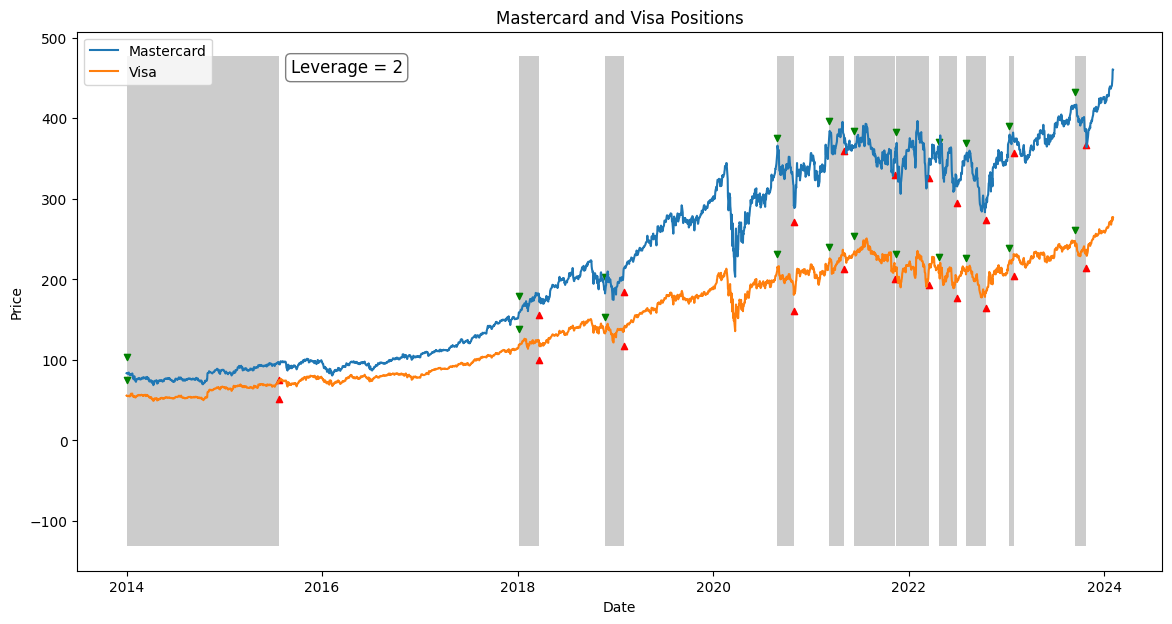

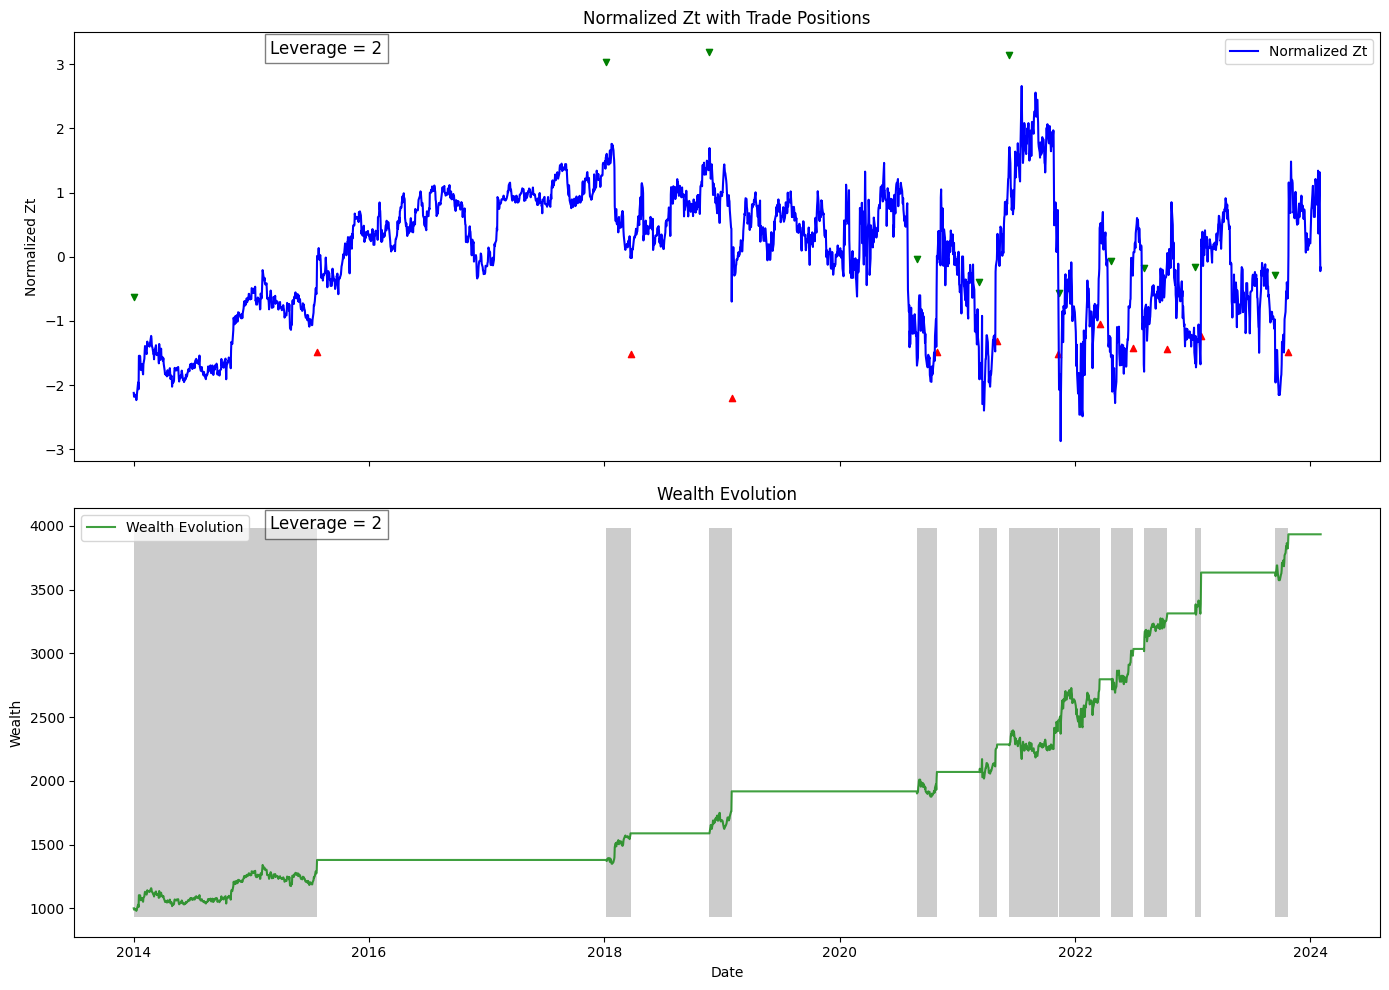

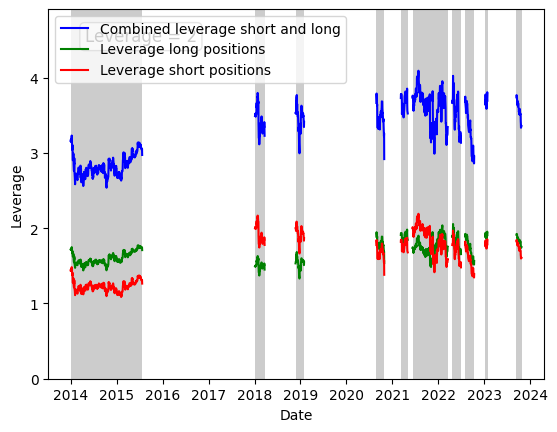

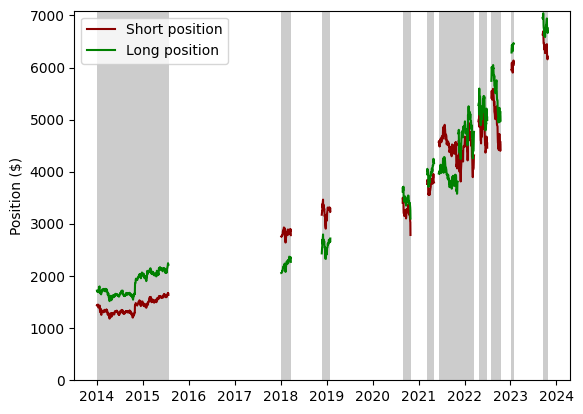

In [179]:
## Plot the figures
Visualize = plot_simulation(positions, date_close, date_open, DS, spread_norm, leverage_limit=2)
Visualize

# Question 4.8 : Recompute the simulation strategy with a leverage limit entry of 20 for the short position. 

In [180]:
# Compute the Trading Strategy without stop with L=20
DS_L20, date_open_L20, date_close_L20, positions_L20 = TradingStrategy(
    P_A=asset_A_prices,
    P_B=asset_B_prices,
    normalized_res=spread_norm,
    W=1000,
    L=20,
    signal_in=1.5,
    stop=None,
) 

In [181]:
# Print the results
print_results(DS_L20)

Metric                                         Value
---------------------------------------------  ----------
Final Wealth                                   515636.77$
Profit                                         514636.77$
Largest Wealth                                 515636.77$
Lowest Wealth                                  943.32$
Total Return                                   51463.68%
Number of Trades                               11
Buy and Hold Strategy Comparison - Visa        397.9%
Buy and Hold Strategy Comparison - Mastercard  451.29%


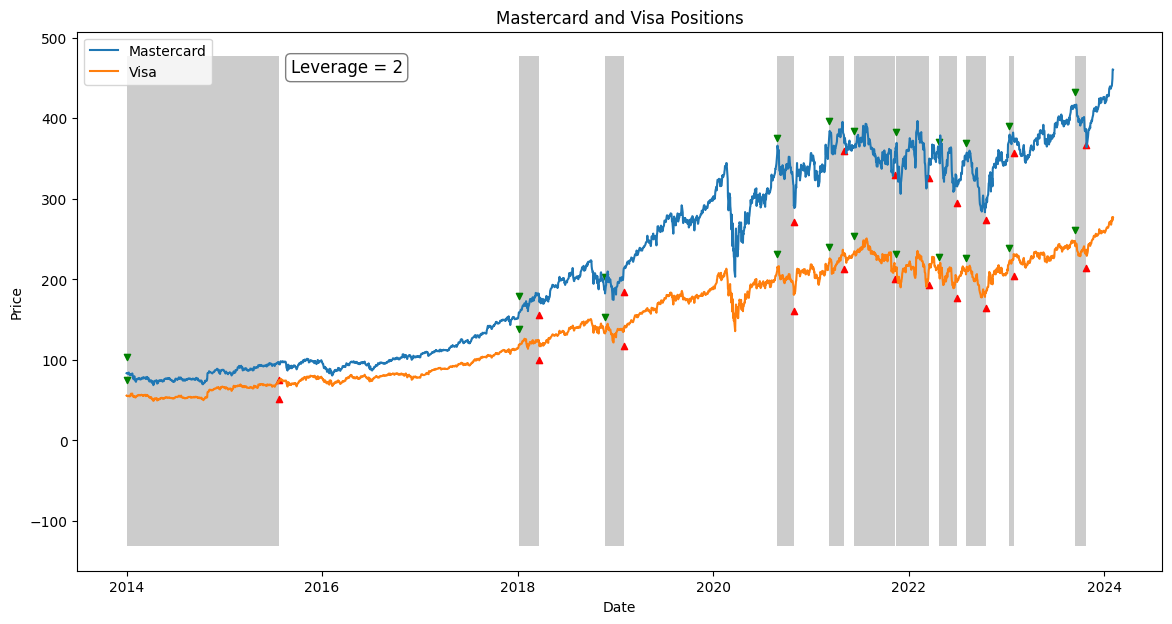

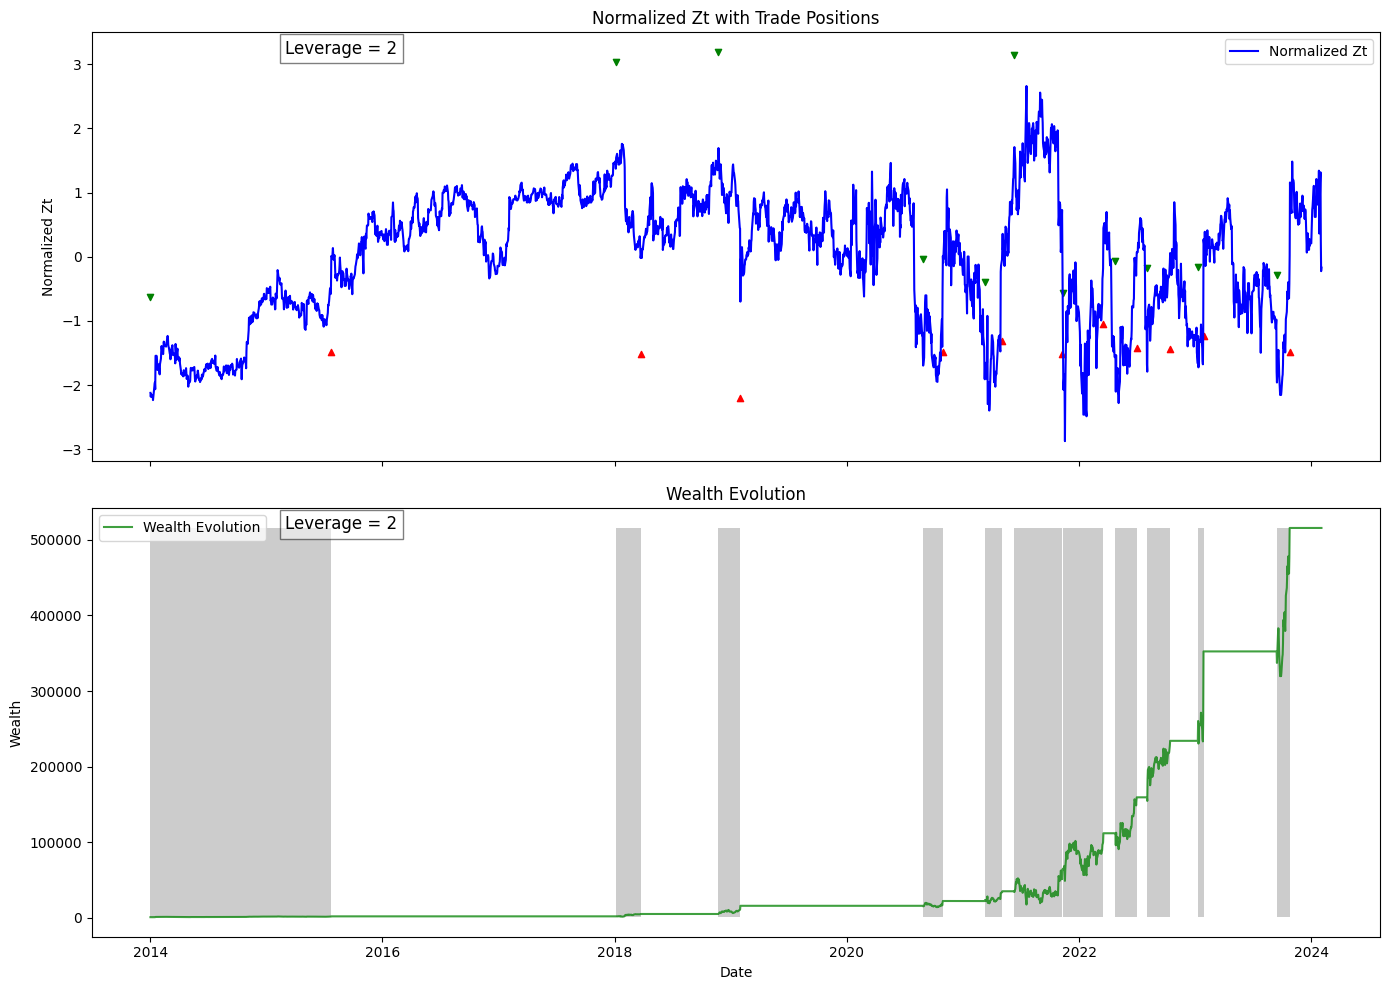

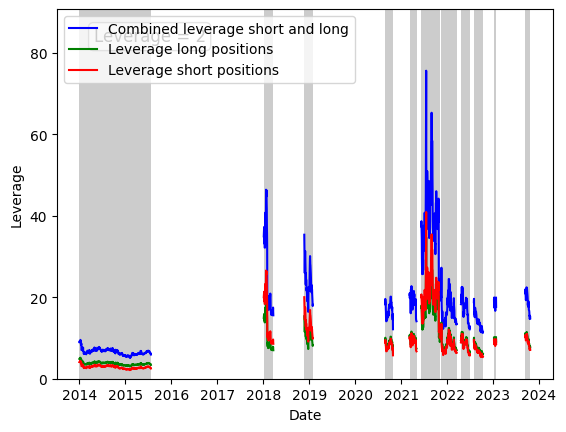

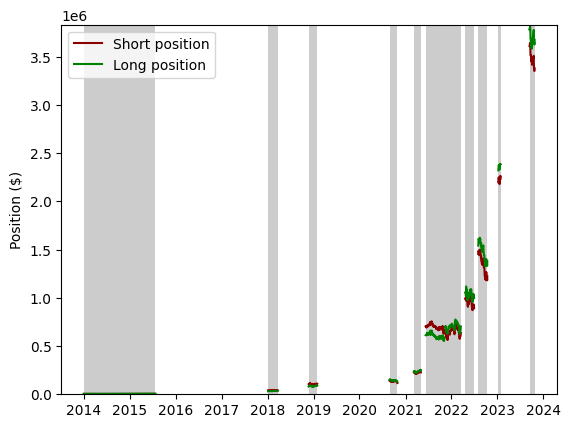

In [182]:
## Plot the figures
Visualize_L20 = plot_simulation(positions_L20, date_close, date_open, DS_L20, spread_norm, leverage_limit=2)
Visualize_L20

# Question 4.9 : Estimate an AR(1) model and use the conditional distribution to compute Pr(˜ zt+1 > ˜ zstop)

In [183]:
# Initialize values
z_init = 1.5
z_stop = 1.75

# Create an AR(1) model
model = AutoReg(spread_norm, lags=1)
results = model.fit()
phi_0 = results.params[0]
phi_1 = results.params[1]


# Method following the question to the letter
# Compute the mean and variance of the AR(1) process
mean = phi_0 / (1 + phi_1)
var = results.sigma2 / (1 - phi_1**2)

# Compute the standardized residuals
z_stop_std = (z_stop - mean) / np.sqrt(var)

# Compute the probability of hitting zstop the day after opening
pr_stop = 1 - norm.cdf(z_stop_std)
print(
    f"The probability that z_t+1 > {z_stop} given z_t = {z_init} is {pr_stop*100:.5f}%."
)


The probability that z_t+1 > 1.75 given z_t = 1.5 is 3.68355%.


# Question 4.10 : Implement the pair-trading strategy with a zstop = 2.75.

In [184]:
# Compute the Trading Strategy by using the function defined previously
DS_stop, date_open, date_close, positions_stop = TradingStrategy(
    P_A=asset_A_prices,
    P_B=asset_B_prices,
    normalized_res=spread_norm,
    W=1000,
    L=2,
    signal_in=1.5,
    stop=2.75,
)

In [185]:
# Print the results
print_results(DS_stop)

Metric                                         Value
---------------------------------------------  --------
Final Wealth                                   3794.96$
Profit                                         2794.96$
Largest Wealth                                 3794.96$
Lowest Wealth                                  980.03$
Total Return                                   279.5%
Number of Trades                               12
Buy and Hold Strategy Comparison - Visa        397.9%
Buy and Hold Strategy Comparison - Mastercard  451.29%


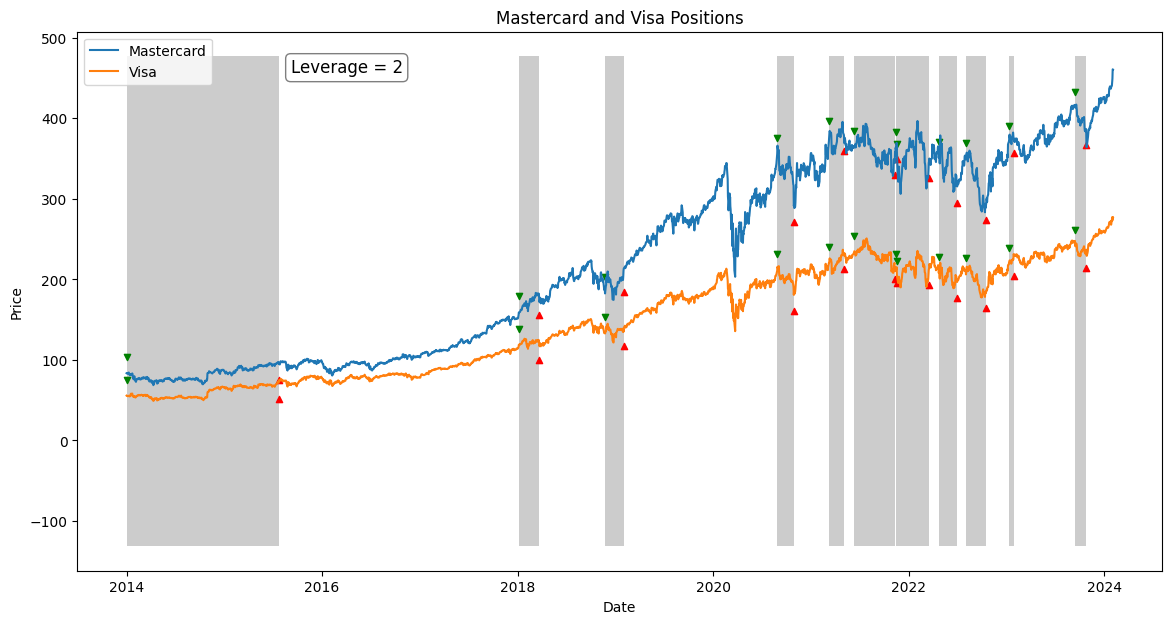

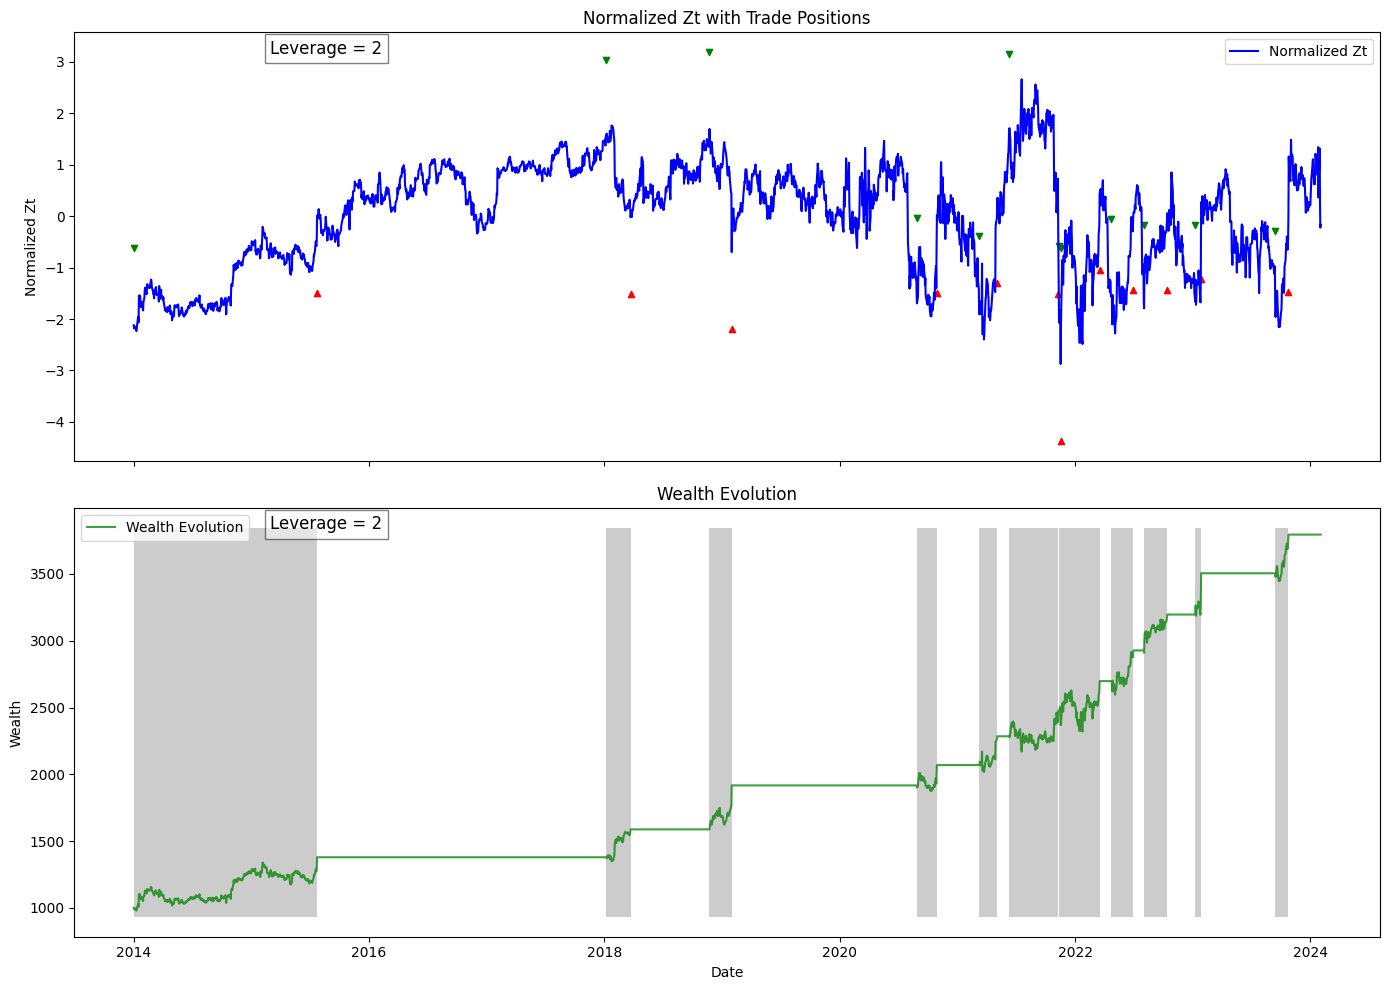

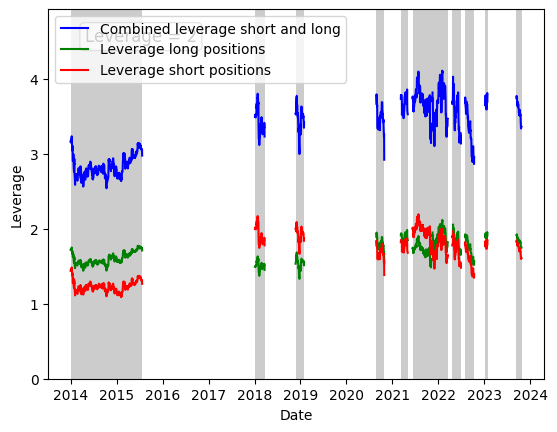

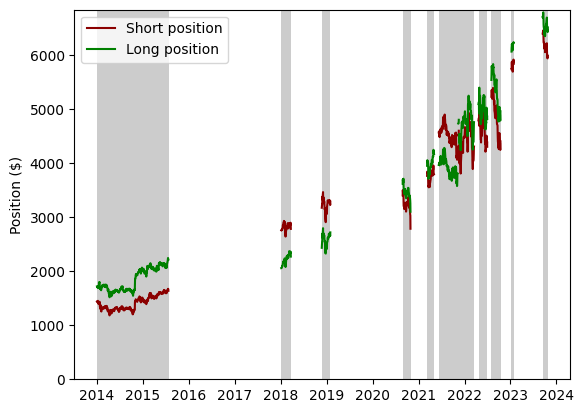

In [186]:
## Plot the figures
Visualize_stop = plot_simulation(positions_stop, date_close, date_open, DS_stop, spread_norm, leverage_limit=2)
Visualize_stop

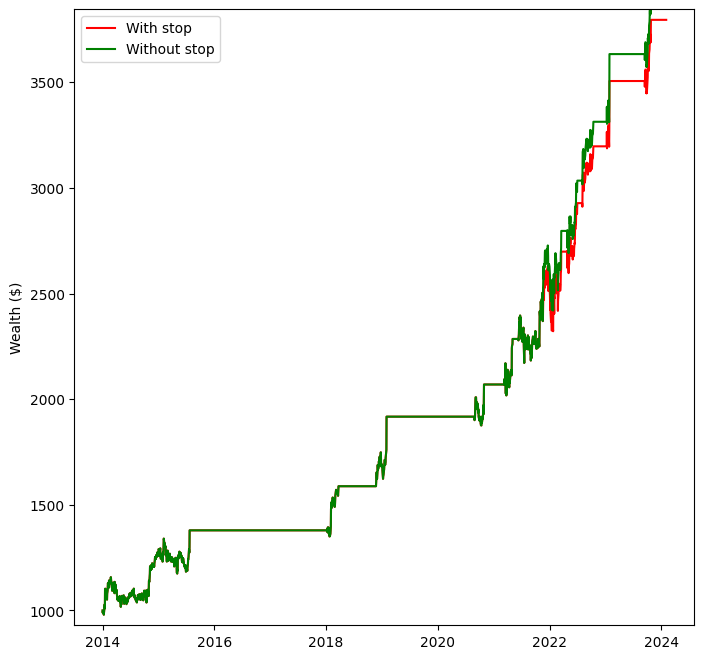

In [187]:
# Plot the comparison with a leverage of 2
# Plot the wealth
fig = plt.figure(figsize=(8, 8))
plt.plot(DS_stop.Wealth, label="With stop", color="red")
plt.plot(DS.Wealth, label="Without stop", color="green")

plt.ylim([DS_stop.Wealth.min() - 50, DS_stop.Wealth.max() + 50])
plt.ylabel("Wealth ($)")
plt.legend()
# plt.savefig("Exo3-7-Comparison.jpg", dpi=150, bbox_inches="tight")
plt.show()


# Question 4.11 : Compute the rolling correlations between prices and returns

In [188]:
# Define a function to compute the rolling window
def Rolling(P_A, P_B, obs: int = 500, window: int = 20, test_co: bool = False):
    """
    This function returns the rolling window of a linear regression between two datasets given and estimate the 
    coefficients parameters for every roll. It also gives the possibility to compute the spread and normalized spread
    with the estimated coefficients.  

    """

    obs = int(obs)
    window = int(window)

    # Initialization of the variable i to 0 and creation of alphas and betas arrays
    # of dimensions rounded to the number of iterations to be performed
    i = 0
    start = 0
    alphas = np.zeros(round((len(P_A) - obs) / window))
    betas = np.zeros(round((len(P_A) - obs) / window))

    # Creation of two empty DataFrame objects to store residus and normalized residus
    spread = pd.DataFrame()
    normalized_res = pd.DataFrame()

    # Create two vector of zeros that will contain the test statistics and pvalue
    test_statistics = np.zeros(ceil((len(P_A) - obs) / window))
    p_values = np.zeros(ceil((len(P_A) - obs) / window))

    dates = []

    while obs < len(P_A):
        # Extraction of sub-lists P_A and P_B corresponding to the current observation window
        A = P_A[start:obs]
        B = P_B[start:obs]

        # Add a constant to the list B, fit a linear regression
        # and store the coefficients alpha and beta
        model = sm.OLS(A, sm.add_constant(B))
        results = model.fit()
        alphas[i] = results.params[0]
        betas[i] = results.params[1]
        dates.append(data.index[obs])

        # Computation of the residuals of the simple linear regression
        # and the corresponding standardized residuals
        residuals = (
            P_A[obs : obs + window] - alphas[i] - betas[i] * P_B[obs : obs + window]
        )
        normalized_residuals = residuals / np.std(residuals)

        # Storage of residues and normalized residues in the corresponding DataFrame objects
        spread = pd.concat([spread, residuals])
        normalized_res = pd.concat([normalized_res, normalized_residuals])

        # If we want to test the cointegration
        if test_co == True:
            residuals = results.resid
            adf_result = adfuller(residuals)
            test_statistics[i] = adf_result[0]
            p_values[i] = adf_result[1]

        i += 1
        obs += window
        start += window

    # If we want to test the cointegration, we return the test statistics and pval
    if test_co == True:
        return spread, normalized_res, alphas, betas, test_statistics, p_values

    return spread, normalized_res, alphas, betas

In [189]:
# Define a function to compute the rolling correlation
def Rolling_corr(P_A, P_B, obs: int = 500, window: int = 20):
    """
    This function allows to use a rolling-window on our prices of two assets
    in order to compute the rolling correlation between these two assets.
    
    This function returns a Numpy ndarray containing the rolling correlation
    """

    obs = int(obs)
    window = int(window)

    # Initialization of the variable i to 0 and creation of alphas and betas arrays
    # of dimensions rounded to the number of iterations to be performed
    i = 0
    start = 0
    dates = []
    prices_corr = np.zeros(round((len(P_A) - obs) / window))

    # Compute the rolling correlation
    while obs < len(P_A):
        prices_corr[i] = P_A[start:obs].corr(P_B[start:obs])
        dates.append(data.index[obs])
        i += 1
        obs += window
        start += window

    return prices_corr

In [190]:
## Compute the correlations
# Set the paramters 
obs = 500
window = 20
# Prices and returns
prices_corr = Rolling_corr(asset_A_prices, asset_B_prices, obs, window)
returns_corr = Rolling_corr(asset_A_prices.pct_change(), asset_B_prices.pct_change(), obs, window)


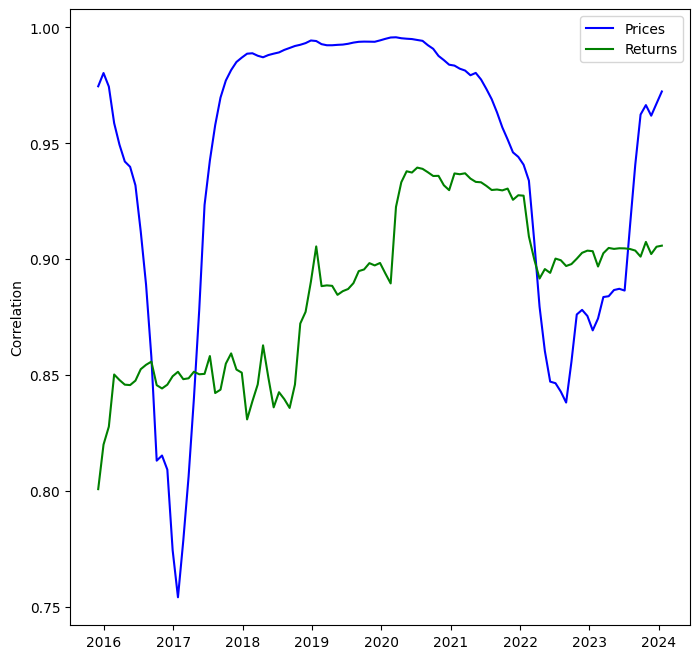

In [191]:
# Dataframe to resume the correlation
correlation = pd.DataFrame(
    {"Prices": prices_corr, "Returns": returns_corr}, index=asset_A_prices[obs::window].index
)

## Graphics
fig = plt.figure(figsize=(8, 8))
plt.plot(correlation.Prices, label="Prices", color="blue")
plt.plot(correlation.Returns, label="Returns", color="green")
plt.ylabel("Correlation")
plt.legend()
# plt.savefig("Exo3-8.jpg", dpi=150, bbox_inches="tight")
plt.show()

# Question 4.12 :  estimate the parameters ˆ αt and ˆ βt on each subsample. Plot the dynamics of the parameters estimates and plot the in-sample spread and the out-ofsample spread together.

In [192]:
### Compute the parameters, the spread and the normalized residuals
spread_oos, normalized_res_oos, alphas_oos, betas_oos = Rolling(asset_A_prices, asset_B_prices, obs, window)
params_oos = pd.DataFrame(
    {"alpha": alphas_oos, "beta": betas_oos}, index=asset_A_prices[obs::window].index
)


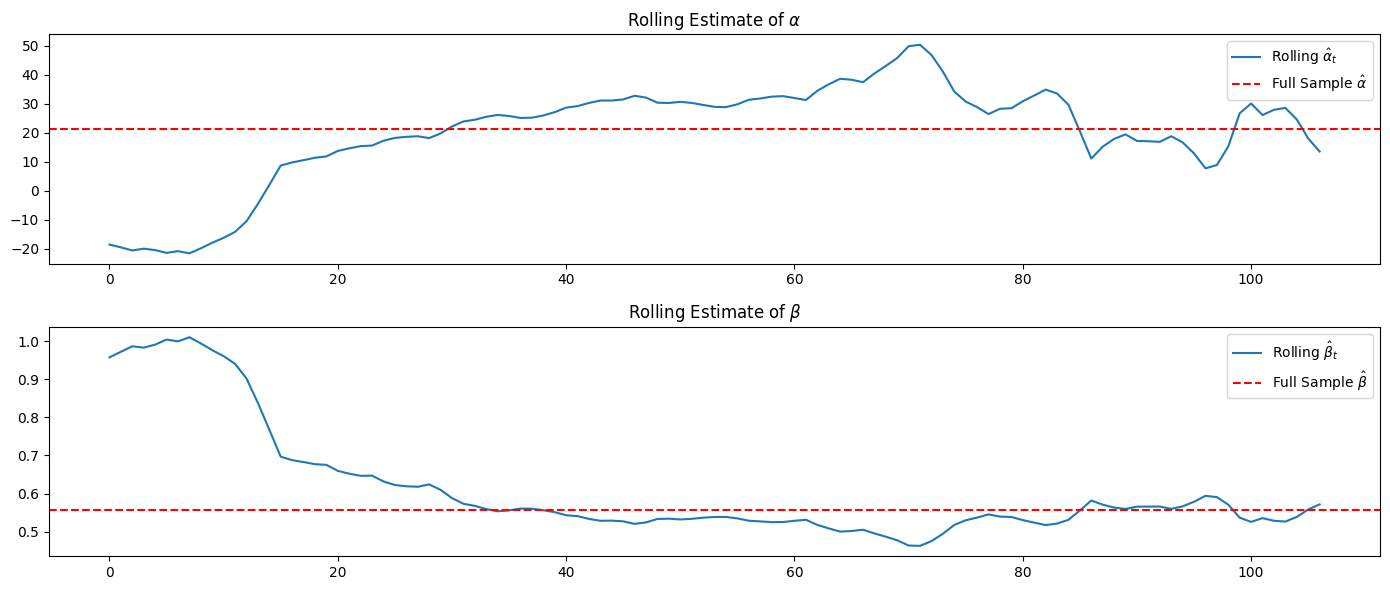

In [193]:
# Step 2: Plot parameter dynamics
plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 1)
plt.plot(alphas_oos, label='Rolling $\\hat{\\alpha}_t$')
plt.axhline(y=alpha, color='r', linestyle='--', label='Full Sample $\\hat{\\alpha}$')
plt.legend()
plt.title('Rolling Estimate of $\\alpha$')

plt.subplot(2, 1, 2)
plt.plot(betas_oos, label='Rolling $\\hat{\\beta}_t$')
plt.axhline(y=beta, color='r', linestyle='--', label='Full Sample $\\hat{\\beta}$')
plt.legend()
plt.title('Rolling Estimate of $\\beta$')
plt.tight_layout()
plt.show()

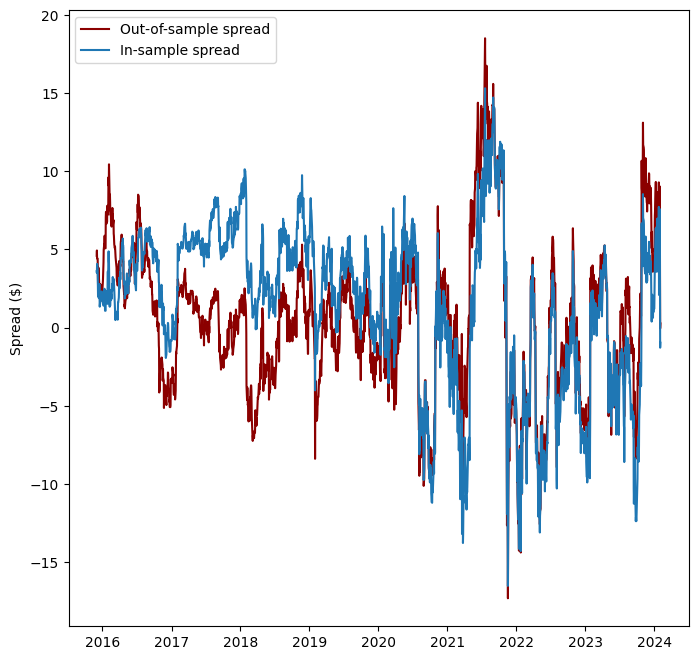

In [194]:
## Plot the spread
fig = plt.figure(figsize=(8, 8))
plt.plot(spread_oos, label="Out-of-sample spread", color="darkred")
plt.plot(
    spread[obs:],  # Matching the number of observations
    label="In-sample spread",
    color="tab:blue",
)
plt.ylabel("Spread ($)")
plt.legend()
# plt.savefig("Exo3-9-spread.jpg", dpi=150, bbox_inches="tight")
plt.show()

# Question 4.13 : Apply the pair-trading strategy using the out-of-sample spread

In [195]:
# Compute the strategy with the spread out-of-sample
DS_oos, do_oos, dc_oos, positions_oos = TradingStrategy(
    asset_A_prices[obs:], asset_B_prices[obs:], normalized_res_oos[0], W=1000, L=2, signal_in=1.5, stop=2.75
)

print_results(DS_oos)

Metric                                         Value
---------------------------------------------  --------
Final Wealth                                   3411.27$
Profit                                         2411.27$
Largest Wealth                                 3754.9$
Lowest Wealth                                  970.24$
Total Return                                   241.13%
Number of Trades                               546
Buy and Hold Strategy Comparison - Visa        397.9%
Buy and Hold Strategy Comparison - Mastercard  451.29%


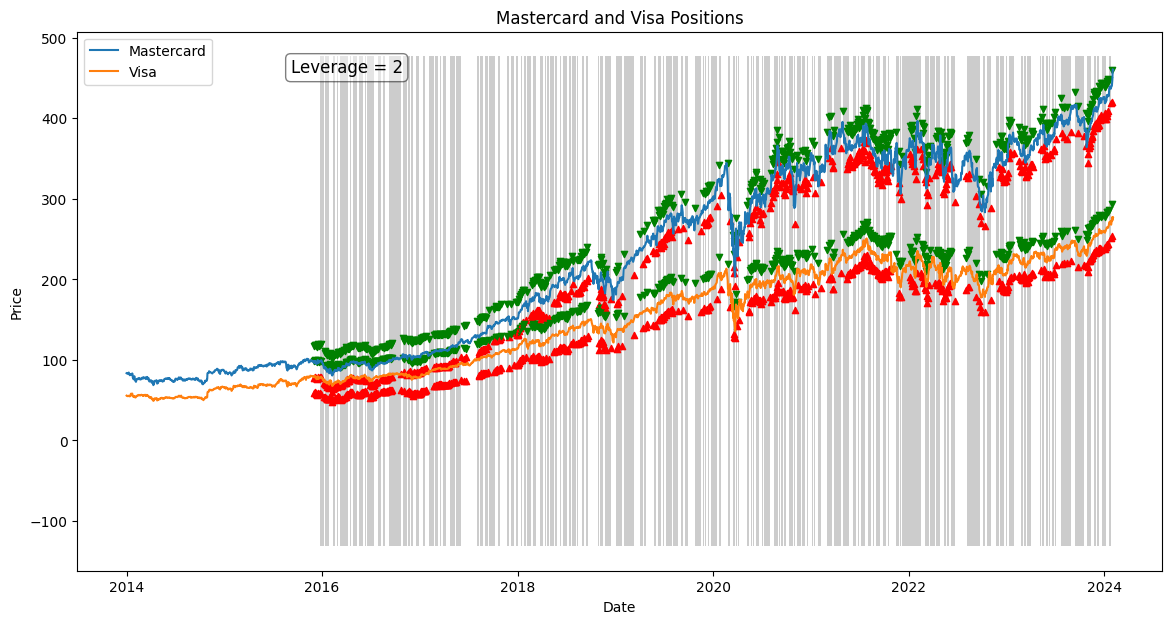

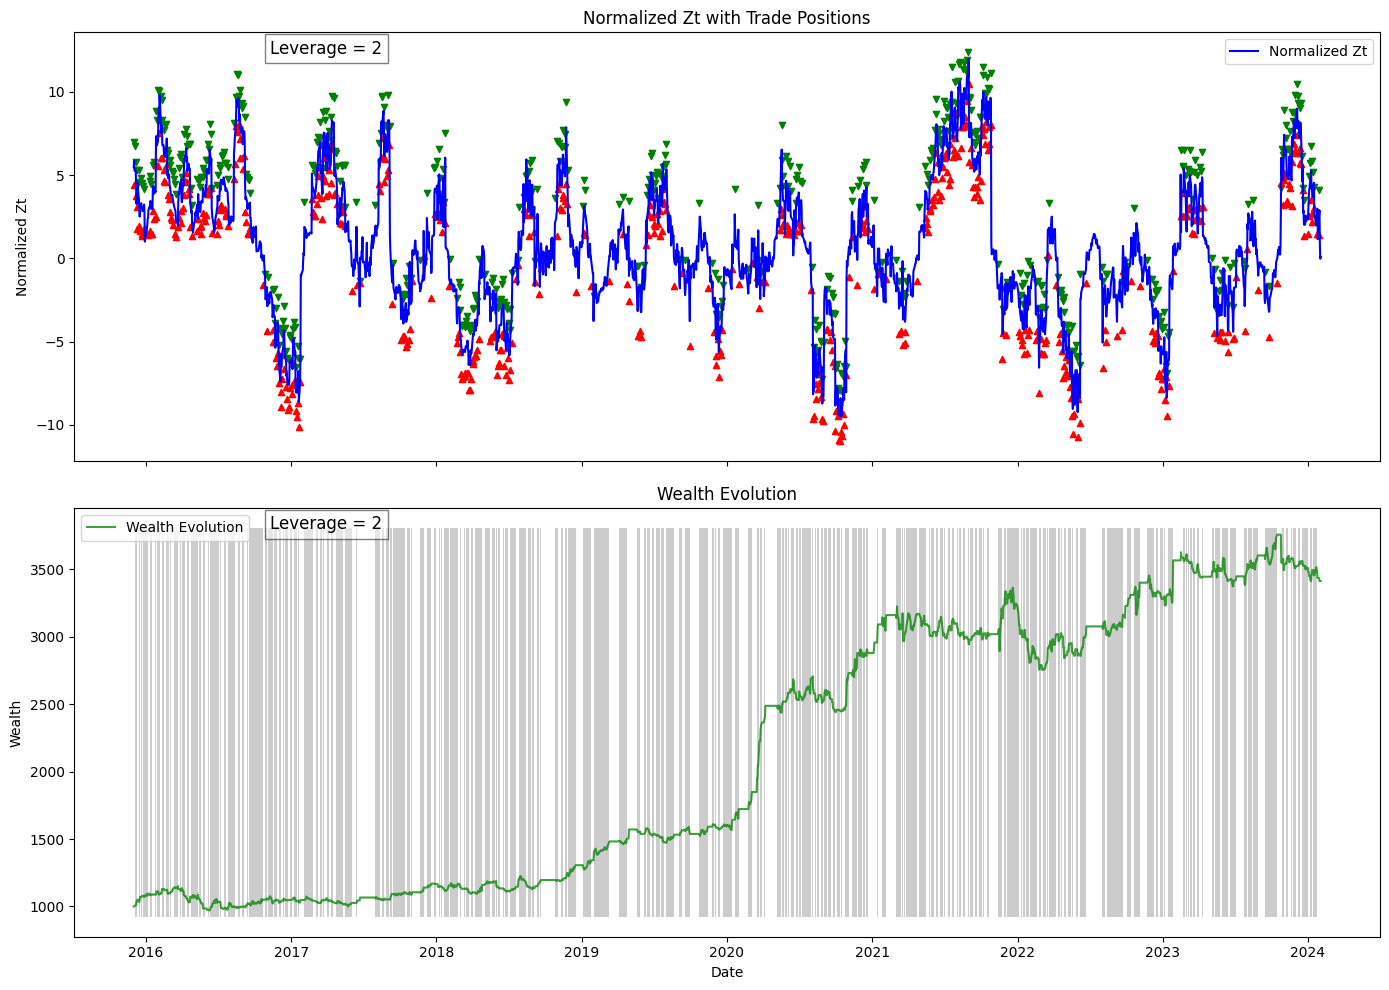

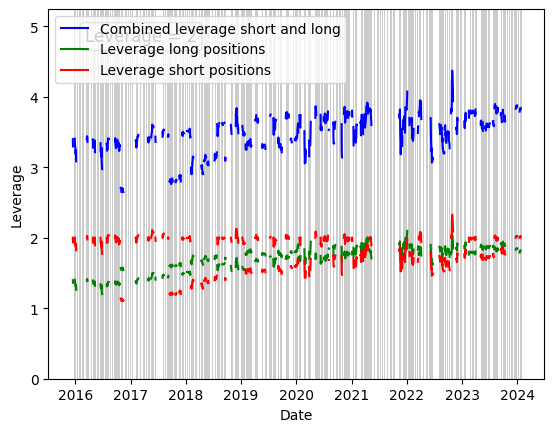

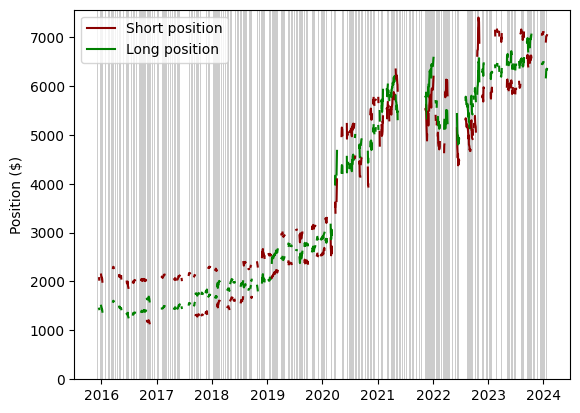

In [196]:
# Plot the simulation 

Visualize_rolling = plot_simulation(positions_oos, dc_oos, do_oos, DS_oos, normalized_res_oos[0], leverage_limit=2)
Visualize_rolling

# Question 4.14 :  Test for cointegration for each subsample and plot the p-values with a stem graph.

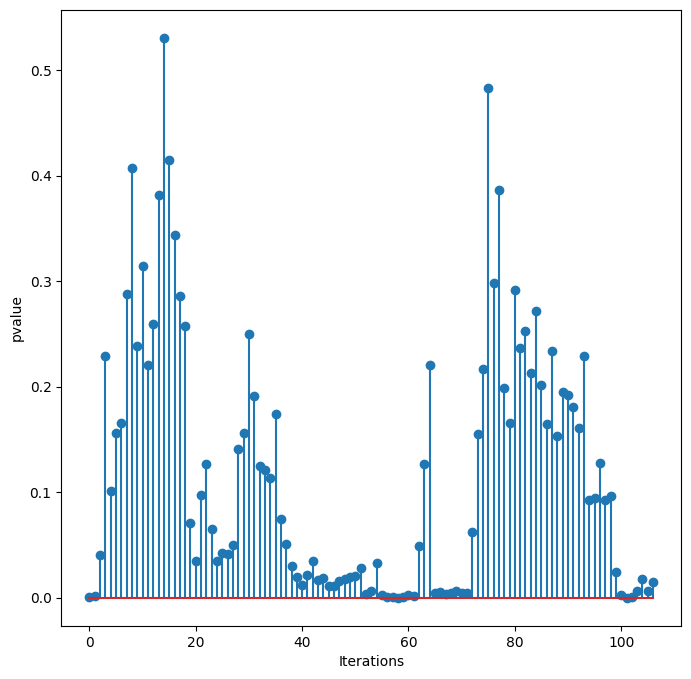

In [197]:
# Compute the pvalues for cointegration
_, _, _, _, test_stat_co, pval_co = Rolling(
    asset_A_prices, asset_B_prices, obs=obs, window=window, test_co=True
)

# Plot the pvalues
fig = plt.figure(figsize=(8, 8))
plt.stem(pval_co)
plt.ylabel("pvalue")
plt.xlabel("Iterations")
# plt.savefig("Exo3-11.jpg", dpi=150, bbox_inches="tight")
plt.show()

# Question 4.15 : Implemtent the cointegration test strategy into the trading simulation and report the performances

In [198]:
# Create a function for the trading strategy
def CointegrationStrategy(
    P_A: pd.core.frame.DataFrame,
    P_B: pd.core.frame.DataFrame,
    normalized_res: np.array,
    p_values: np.array,
    W: float = 1000,
    L: float = 2,
    signal_in: float = 1.5,
    stop: float = 2,
    alph: float = 0.05,
    step: int = 20,
):
    """
    Complement the previous function by adding cointegration conditions inside our trading strategy.

    """

    # Initialize new variables that will contain the short position, long position,
    # the wealth and the trading cointegration vectors
    short = np.zeros(len(P_A))
    long = np.zeros(len(P_A))
    wealth = np.zeros(len(P_A))
    wealth[0] = W    
    coint_critic = np.zeros(len(P_A))

    # Calculation of the variable to determine whether or not there is
    # cointegration and whether a position should therefore be closed
    l = 0
    for j in range(len(p_values)):
        for i in range(l, l + step):
            if i == len(P_A):
                break
            coint_critic[i] = p_values[j] - alph
        l += step

    # Create variables for the number of asset A and B buy/short and the signal
    Q_A, Q_B = 0, 0
    signal, nb_trades = 0, 0
    date_open, date_close = [], []
    positions = [] # Track every trades positions
    current_trade = {} # Create a dictionary for every positions in order to track their informations


    # Start the trading strategy
    for i in range(len(P_A)):
        # In the case we have cointegration, we can open a position if
        # a signal is given
        if coint_critic[i] <= 0:

            # Compute the Signal 1:
            if signal == 1:
                if (normalized_res[i] <= 0) or (normalized_res[i] > stop):
                    # We close our positions and compute the wealth
                    wealth[i] = wealth[i-1] + Q_B*(P_B[i]-P_B[i-1]) + Q_A*(P_A[i-1]-P_A[i])
                    
                    # Add the new existing informations into our dictionary about the position
                    current_trade['zt_exit'] = normalized_res.iloc[i]
                    current_trade['exit_observation'] = P_A.index[i]
                    current_trade['mastercard_quantity'] = Q_B
                    current_trade['mastercard_exit_price'] = P_B[i-1]
                    current_trade['visa_quantity'] = Q_A
                    current_trade['visa_exit_price'] = P_A[i-1]

                    positions.append(current_trade) # Save the informations about our trade now that the position is closed 
                    current_trade = {} # Reset current trade dictionary for the next position
                

                    # Reset the values to zero as the positions are closed
                    Q_A, Q_B = 0, 0
                    short[i], long[i] = 0, 0
                    signal = 0
                    date_close.append(P_A.index[i])

                elif normalized_res.iloc[i] > 0:
                    # We take a short position in asset A and
                    # a long position in asset B
                    short[i] = Q_A*P_A[i]
                    long[i] = Q_B*P_B[i]
                    wealth[i] = wealth[i-1] + Q_B*(P_B[i]-P_B[i-1]) + Q_A*(P_A[i-1]-P_A[i])


            # Compute the Signal 2:
            elif signal == 2:
                if (normalized_res[i] >= 0) or (normalized_res[i] < -stop):
                    # We close our positions and compute the wealth
                    wealth[i] = wealth[i-1]+ Q_B*(P_B[i-1]-P_B[i]) + Q_A*(P_A[i]-P_A[i-1])


                    # Add the new existing informations into our dictionary about the position
                    current_trade['zt_exit'] = normalized_res.iloc[i]
                    current_trade['exit_observation'] = P_A.index[i]
                    current_trade['mastercard_quantity'] = Q_B
                    current_trade['mastercard_exit_price'] = P_B[i-1]
                    current_trade['visa_quantity'] = Q_A
                    current_trade['visa_exit_price'] = P_A[i-1]

                    positions.append(current_trade) # Save the informations about our trade now that the position is closed 
                    current_trade = {} # Reset current trade dictionary for the next position

                    
                    # Reset the values to zero as the positions are closed
                    Q_A, Q_B = 0, 0
                    short[i], long[i] = 0, 0
                    signal = 0
                    date_close.append(P_A.index[i])
                        
                elif normalized_res.iloc[i] < 0:
                    # We take a short position in asset B and
                    # a long position in asset A
                    short[i] = Q_B*P_B[i]
                    long[i] = Q_A*P_A[i]
                    wealth[i] = wealth[i-1] + Q_B*(P_B[i-1]-P_B[i]) + Q_A*(P_A[i]-P_A[i-1])
                    

            elif signal == 0:

                if alpha > 0:
                    if normalized_res[i] > signal_in:
                        # We can determine the number of shares that we buy and sell.
                        # Here, we will short A and long B.
                        if i != 0 :
                            wealth[i] = wealth[i-1] 

                        Q_A = (L * wealth[i]) / P_A[i]
                        Q_B = beta * Q_A

                        short[i] = Q_A * P_A[i]
                        long[i] = Q_B * P_B[i]

                        signal = 1
                        nb_trades += 1
                        date_open.append(P_A.index[i])
                        
                        current_trade = { 
                            'entry_signal': "Signal 1", 
                            'zt_entry': normalized_res.iloc[i], 
                            'entry_observation': P_A.index[i], 
                            'mastercard_entry_price': P_B[i], 
                            'mastercard_quantity': Q_B, 
                            'visa_entry_price': P_A[i], 
                            'visa_quantity': Q_A
                        }   

                    elif normalized_res[i] < -signal_in:
                        # We can determine the number of shares that we buy and sell.
                        # Here, we will short B and long A.
                        # Solve for x
                        if i != 0 :
                            wealth[i] = wealth[i-1]
                 
                        Q_A = (L * wealth[i]) / (beta*P_B[i] + L*(P_A[i] - beta*P_B[i]))
                        Q_B = beta * Q_A

                        short[i] = Q_B * P_B[i]
                        long[i] = Q_A * P_A[i]
                        signal = 2
                        nb_trades += 1
                        date_open.append(P_A.index[i])
                        current_trade = { 
                            'entry_signal': "Signal 2", 
                            'zt_entry': normalized_res.iloc[i], 
                            'entry_observation': P_A.index[i], 
                            'mastercard_entry_price': P_B[i], 
                            'mastercard_quantity': Q_B, 
                            'visa_entry_price': P_A[i], 
                            'visa_quantity': Q_A
                        }   

                    else:
                        short[i] = 0
                        long[i] = 0
                        if i != 0 :
                            wealth[i] = wealth[i-1]

                if alpha < 0 :
                    if normalized_res.iloc[i] > signal_in:
                        # We can determine the number of shares that we buy and sell.
                        # Here, we will short A and long B.
                        if i != 0 :
                            wealth[i] = wealth[i-1]
                        
                        Q_A = (L * wealth[i]) / (P_A[i] - L*(P_A[i] - beta*P_B[i]))
                        Q_B = beta * Q_A

                        short[i] = Q_A * P_A[i]
                        long[i] = Q_B * P_B[i]
                        signal = 1
                        nb_trades += 1
                        date_open.append(P_A.index[i])
                        current_trade = { 
                            'entry_signal': "Signal 1", 
                            'zt_entry': normalized_res.iloc[i], 
                            'entry_observation': P_A.index[i], 
                            'mastercard_entry_price': P_B[i], 
                            'mastercard_quantity': Q_B, 
                            'visa_entry_price': P_A[i], 
                            'visa_quantity': Q_A
                        }   
                        
                    elif normalized_res.iloc[i] < -signal_in:
                        # We can determine the number of shares that we buy and sell.
                        # Here, we will short B and long A.
                        # Solve for x
                        if i != 0 :
                            wealth[i] = wealth[i-1]
                        
                        Q_A = (L * wealth[i]) / (beta * P_B[i])
                        Q_B = beta * Q_A

                        short[i] = Q_B * P_B[i]
                        long[i] = Q_A * P_A[i]
                        signal = 2
                        nb_trades += 1
                        date_open.append(P_A.index[i])

                        current_trade = { 
                            'entry_signal': "Signal 2", 
                            'zt_entry': normalized_res.iloc[i], 
                            'entry_observation': P_A.index[i], 
                            'mastercard_entry_price': P_B[i], 
                            'mastercard_quantity': Q_B, 
                            'visa_entry_price': P_A[i], 
                            'visa_quantity': Q_A
                        }   

                    else:
                        short[i] = 0
                        long[i] = 0
                        if i != 0 :
                            wealth[i] = wealth[i-1]   

        # In the case we don't have cointegration, close the positions if some are open
        else:
            if signal == 0:
                # No positions are open
                short[i] = 0
                long[i] = 0
                wealth[i] = wealth[i-1]

            elif signal == 1:
                # We close our positions and compute the wealth
                wealth[i] = wealth[i-1] + Q_B*(P_B[i]-P_B[i-1]) + Q_A*(P_A[i-1]-P_A[i])

                # Add the new existing informations into our dictionary about the position
                current_trade['zt_exit'] = normalized_res.iloc[i]
                current_trade['exit_observation'] = P_A.index[i]
                current_trade['mastercard_quantity'] = Q_B
                current_trade['mastercard_exit_price'] = P_B[i-1]
                current_trade['visa_quantity'] = Q_A
                current_trade['visa_exit_price'] = P_A[i-1]

                positions.append(current_trade) # Save the informations about our trade now that the position is closed 
                current_trade = {} # Reset current trade dictionary for the next position

                Q_A, Q_B = 0, 0
                short[i], long[i], signal = 0, 0, 0
                date_close.append(P_A.index[i])

            elif signal == 2:
                # We close our positions and compute the wealth
                wealth[i] = wealth[i-1]+ Q_B*(P_B[i-1]-P_B[i]) + Q_A*(P_A[i]-P_A[i-1])

                # Add the new existing informations into our dictionary about the position
                current_trade['zt_exit'] = normalized_res.iloc[i]
                current_trade['exit_observation'] = P_A.index[i]
                current_trade['mastercard_quantity'] = Q_B
                current_trade['mastercard_exit_price'] = P_B[i-1]
                current_trade['visa_quantity'] = Q_A
                current_trade['visa_exit_price'] = P_A[i-1]

                positions.append(current_trade) # Save the informations about our trade now that the position is closed 
                current_trade = {} # Reset current trade dictionary for the next position

                Q_A, Q_B = 0, 0
                short[i], long[i], signal = 0, 0, 0
                date_close.append(P_A.index[i])

    result = pd.DataFrame(
        {
            "Signal": normalized_res,
            "Wealth": wealth,
            "Short": short,
            "Long": long,
            "Trading": coint_critic,
            "Leverage": (short + long) / wealth,
            "Long_leverage": long / wealth, 
            "Short_leverage": short / wealth,
            "Nb_trades": nb_trades, 
        }
    )

    positions_df = pd.DataFrame(positions)

    return result, date_open, date_close, positions_df

In [199]:
# Make the trading strategy with cointegration
DS_CS, do_CS, dc_CS, positions_CS = CointegrationStrategy(
    asset_A_prices[obs:],
    asset_B_prices[obs:],
    normalized_res_oos[0],
    p_values=pval_co,
    W=1000,
    L=2,
    signal_in=1.5,
    stop=2.75,
    alph=0.05,
    step=20,
)

print_results(DS_CS)

Metric                                         Value
---------------------------------------------  --------
Final Wealth                                   2295.52$
Profit                                         1295.52$
Largest Wealth                                 2526.75$
Lowest Wealth                                  1000.0$
Total Return                                   129.55%
Number of Trades                               203
Buy and Hold Strategy Comparison - Visa        397.9%
Buy and Hold Strategy Comparison - Mastercard  451.29%


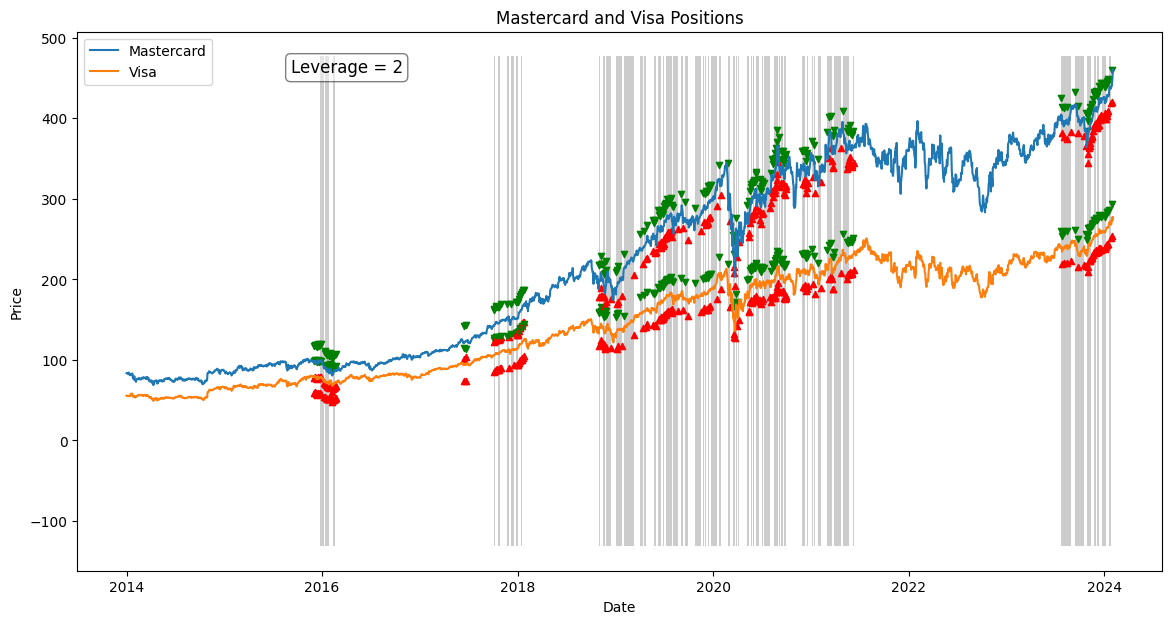

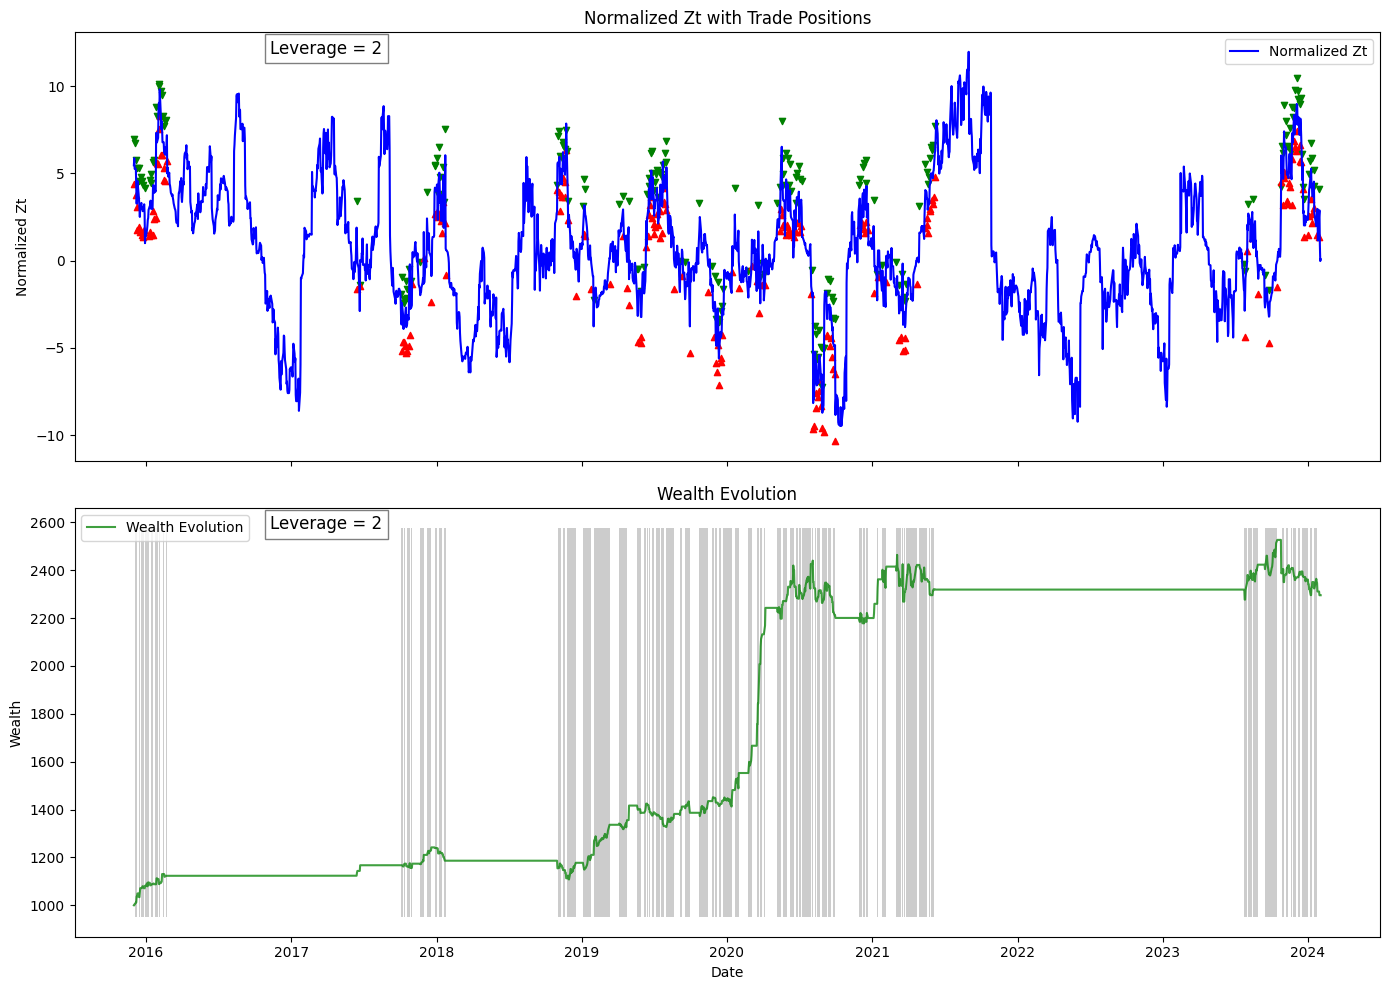

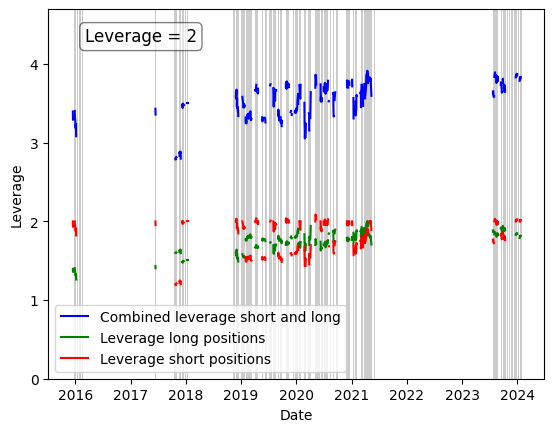

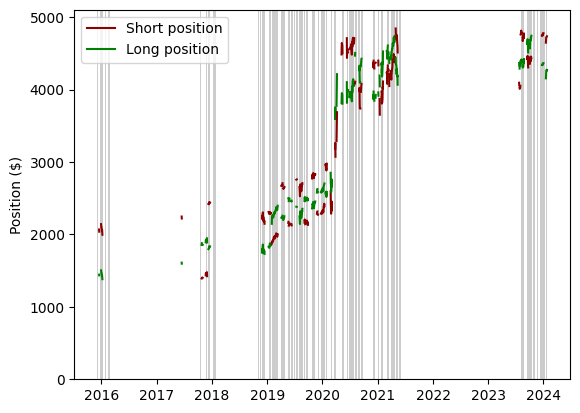

In [200]:
# Plot the graphs

Visualize_coint = plot_simulation(positions_CS, dc_CS, do_CS, DS_CS, normalized_res_oos[0], leverage_limit=2)
Visualize_coint